#Objectives


This project focuses on making travel more efficient and eco-friendly by creating smart carpooling groups. The goal is to reduce both the total cost of trips and the amount of CO₂ emissions by grouping people who travel in similar directions, with an emphasis on CO2 emissions. We wanted to understand whether clustering helps or limits carpool formation. In order to evaluate this, we wanted to compare a clustering-based pipeline (KMeans, AGNES) with a greedy no-cluster strategy that only uses route, time, and driver availability. This showed us the maximum possible number of people that can be included in carpooling, and how well clustering improves cost and CO₂ optimization. A very detailed report and result comparison can be found in the submitted Report.

# Import all necessary libraries

In [ ]:
pip install gower

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import gower
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from datetime import timedelta
from sklearn.cluster import AgglomerativeClustering

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading necessary files

In [ ]:
missions = pd.read_csv("/content/missions_fixed_600.csv")
persons = pd.read_csv("/content/persons_fixed_600.csv")
co2 = pd.read_csv("/content/co22.csv")

##Calculation of total CO2 and cost without any algorithm applied, from raw data

In [ ]:
import pandas as pd

# merging datasets
df = missions.merge(persons, on="person_id", how="left")

# filling missing car_model for train/plane cases, just to avoid any errors, if missing use average carpool as in greedy and evaluation/optimization functions
df["car_model"] = df["car_model"].fillna("average_carpool")

# merging with CO₂ emissions to obtain emmission values
df = df.merge(co2, on="car_model", how="left")

# plane and train CO₂
co2_plane = co2[co2["car_model"] == "plane"]["co2_per_km"].values[0]
co2_train = co2[co2["car_model"] == "TER"]["co2_per_km"].values[0]

# assigning correct CO₂ per km based on travel_type
def assign_co2(row):
    if row["travel_type"] == "plane":
        return co2_plane
    elif row["travel_type"] == "train":
        return co2_train
    else:  # default to value from car_model merge
        return row["co2_per_km"]

df["co2_corrected_per_km"] = df.apply(assign_co2, axis=1)

# calculate emissions
df["co2_emission_kg"] = df["km"].fillna(0) * df["co2_corrected_per_km"].fillna(0)

# total cost preprocessing
df["total_cost"] = df["total_cost"].fillna(0)

# summing up
total_co2 = df["co2_emission_kg"].sum()
total_cost = df["total_cost"].sum()

print(f"Total CO₂ emissions: {total_co2:.2f} kg")
print(f"Total travel cost: €{total_cost:.2f}")



Total CO₂ emissions: 51793.98 kg
Total travel cost: €221182.00


# Initial carpooling fuction (still suboptimal, no train fallback logic)

In [ ]:
def evaluate_clustered_carpooling(csv_path, co2_path="/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", cluster_col="cluster_kmeans"):

    df = pd.read_csv(csv_path)
    co2_df = pd.read_csv(co2_path)

    df["start_date"] = pd.to_datetime(df["start_date"])
    df["end_date"] = pd.to_datetime(df["end_date"])
    df["co2_emission_kg"] = df["km"] * df["co2_per_km"]
    df["has_car"] = df["has_car"].fillna(False)
    df["car_capacity"] = df["car_capacity"].fillna(0)

    carbon_tax_rate = 0.0446  # €/kg CO₂
    co2_train = co2_df[co2_df["car_model"] == "TER"]["co2_per_km"].values[0]
    carpool_groups = []
    used_person_ids = set()
    group_id = 1

    for cluster in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cluster]

        for (start_city, end_city), route_df in cluster_df.groupby(["start_city", "end_city"]):
            route_df = route_df.sort_values("start_date")

            # Only eligible drivers
            drivers_df = route_df[
                (route_df["has_car"] == True) &
                (route_df["car_capacity"] > 0) &
                (~route_df["person_id"].isin(used_person_ids))
            ]

            for _, driver in drivers_df.iterrows():
                if driver["person_id"] in used_person_ids:
                    continue

                capacity = int(driver["car_capacity"])
                if capacity < 1:
                    continue

                passengers_df = route_df[
                    (~route_df["person_id"].isin(used_person_ids)) &
                    (route_df["person_id"] != driver["person_id"]) &
                    (route_df["has_car"] == False) &
                    (route_df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                    (route_df["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                    (route_df["start_city"] == driver["start_city"]) &
                    (route_df["end_city"] == driver["end_city"])
                ]

                selected_passengers = passengers_df.head(capacity)

                #forming group (solo driver or driver + passengers)
                group_df = pd.concat([pd.DataFrame([driver]), selected_passengers])
                group_df["carpool_group_id"] = f"group_{group_id}"
                group_df["cluster"] = cluster
                group_df["travel_mode"] = "carpool"

                used_person_ids.add(driver["person_id"])
                used_person_ids.update(selected_passengers["person_id"].values)
                carpool_groups.append(group_df)
                group_id += 1

    # handling unassigned people (solo fallback logic)
    unassigned = df[~df["person_id"].isin(used_person_ids)].copy()
    for _, row in unassigned.iterrows():
        row = row.copy()
        row["carpool_group_id"] = f"group_{group_id}"
        row["cluster"] = row[cluster_col]

        if row["has_car"]:
            row["travel_mode"] = "car (solo)"
            co2_used = row["co2_per_km"]
        else:
            row["travel_mode"] = "train (solo)"
            co2_used = co2_train
            print(f"\n[Info] {row['first_name']} {row['last_name']} (ID: {row['person_id']}) assigned to solo train travel.")

        row["co2_emission_kg"] = co2_used * row["km"]
        carpool_groups.append(pd.DataFrame([row]))
        used_person_ids.add(row["person_id"])
        group_id += 1

    # Final results
    if carpool_groups:
        carpool_df = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])

        total_co2 = carpool_df["co2_emission_kg"].sum()
        co2_tax = total_co2 * carbon_tax_rate

        for group_id, group in carpool_df.groupby("carpool_group_id"):
            # Display group info
            driver_row = group[group["has_car"] == True]
            if driver_row.empty:
                solo = group.iloc[0]
                print(f"\nGroup {solo['carpool_group_id']} | Cluster: {solo['cluster']}")
                print(f"Route: {solo['start_city']} ➝ {solo['end_city']}")
                print(f"Start Dates: {solo['start_date'].date()} – {solo['end_date'].date()}")
                print(f"Solo Travel: {solo['travel_mode']}")
                print(f"Traveler: {solo['first_name']} {solo['last_name']} (ID: {solo['person_id']})")
            else:
                driver = driver_row.iloc[0]
                passengers = group[group["has_car"] == False]

                print(f"\nGroup {group_id} | Cluster: {group['cluster'].iloc[0]}")
                print(f"Route: {driver['start_city']} ➝ {driver['end_city']}")
                print(f"Start Dates: {group['start_date'].min().date()} – {group['start_date'].max().date()}")
                print(f"Driver: {driver['first_name']} {driver['last_name']} (ID: {driver['person_id']})")
                if not passengers.empty:
                    print("Passengers:")
                    for _, p in passengers.iterrows():
                        print(f"  - {p['first_name']} {p['last_name']} (ID: {p['person_id']})")
                else:
                    print("(No passengers – solo driver)")

            # HOTEL COSTS per person based on group event range
            event_start = group["start_date"].min().normalize()
            event_end = group["end_date"].max().normalize()

            for i, person in group.iterrows():
                person_start = person["start_date"].normalize()
                person_end = person["end_date"].normalize()

                early_nights = (event_start - person_start).days
                late_nights = (person_end - event_end).days

                early_nights = min(max(early_nights, 0), 2)
                late_nights = max(late_nights, 0)

                extra_night_cost = (early_nights + late_nights) * person["hotel_cost"]

                total_person_cost = person["hotel_cost"] + extra_night_cost + person["parking_cost"]
                carpool_df.loc[i, "computed_total_cost"] = total_person_cost

                if extra_night_cost > 0:
                    print(f"  [Hotel Cost] {person['first_name']} {person['last_name']} "
                          f"(ID: {person['person_id']}) → +€{extra_night_cost} (extra nights)")


        # compute and display total summary
        total_cost = carpool_df["computed_total_cost"].sum()

        print(f"\nCluster-based Carpool Evaluation — Source: {csv_path}")
        print(f"Total groups formed: {carpool_df['carpool_group_id'].nunique()}")
        print(f"Total people assigned: {carpool_df['person_id'].nunique()}")
        print(f"Total cost: €{round(total_cost, 2)}")
        print(f"Total CO₂ emission: {round(total_co2, 2)} kg")
        print(f"CO₂ tax: €{round(co2_tax, 2)}")

    else:
        print("\nNo valid carpool groups formed.")


# Final optimized carpooling function

In [ ]:
def evaluate_optimized_carpooling(csv_path, co2_path, cluster_col="cluster_kmeans"):

    df = pd.read_csv(csv_path)
    co2_df = pd.read_csv(co2_path)

    df["start_date"] = pd.to_datetime(df["start_date"])
    df["end_date"] = pd.to_datetime(df["end_date"])
    df["has_car"] = df["has_car"].fillna(False)
    df["car_capacity"] = df["car_capacity"].fillna(0)
    df["car_model"] = df["car_model"].fillna("average_carpool")
    df["travel_type"] = df["travel_type"].fillna("unknown")

    df = df.merge(co2_df[["car_model", "car_type", "co2_per_km"]], on="car_model", how="left")
    co2_train = co2_df[co2_df["car_model"] == "TER"]["co2_per_km"].values[0]

    carbon_tax_rate = 0.0446  # €/kg CO₂
    carpool_groups = []
    used_person_ids = set()
    group_id = 1

    train_durations = {
        ("Belfort", "Nice"): 5, ("Besançon", "Marseille"): 4.5,
        ("Montbéliard", "Strasbourg"): 1.5, ("Montbéliard", "Toulouse"): 5,
        ("Belfort", "Paris"): 3, ("Besançon", "Toulouse"): 5.5,
        ("Montbéliard", "Nice"): 5, ("Montbéliard", "Lyon"): 2,
        ("Belfort", "Marseille"): 4.5, ("Besançon", "Nice"): 5,
        ("Besançon", "Strasbourg"): 1.5
    }
    car_durations = {
        ("Belfort", "Nice"): 8, ("Besançon", "Marseille"): 7,
        ("Montbéliard", "Strasbourg"): 2, ("Montbéliard", "Toulouse"): 8,
        ("Belfort", "Paris"): 6, ("Besançon", "Toulouse"): 7,
        ("Montbéliard", "Nice"): 7, ("Montbéliard", "Lyon"): 3,
        ("Belfort", "Marseille"): 7, ("Besançon", "Nice"): 8,
        ("Besançon", "Strasbourg"): 2.5
    }

    # Group people into carpools
    for cluster in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cluster]

        for (start_city, end_city), route_df in cluster_df.groupby(["start_city", "end_city"]):
            route_df = route_df.sort_values("start_date")

            drivers_df = route_df[
                (route_df["has_car"] == True) &
                (route_df["car_capacity"] > 0) &
                (~route_df["person_id"].isin(used_person_ids))
            ]

            for _, driver in drivers_df.iterrows():
                if driver["person_id"] in used_person_ids:
                    continue

                capacity = int(driver["car_capacity"])
                if capacity < 1:
                    continue

                passengers_df = route_df[
                    (~route_df["person_id"].isin(used_person_ids)) &
                    (route_df["person_id"] != driver["person_id"]) &
                    (route_df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                    (route_df["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                    (route_df["start_city"] == driver["start_city"]) &
                    (route_df["end_city"] == driver["end_city"])
                ]

                selected_passengers = passengers_df.head(capacity)
                group_df = pd.concat([pd.DataFrame([driver]), selected_passengers])
                group_df["carpool_group_id"] = f"group_{group_id}"
                group_df["cluster"] = cluster
                group_df["travel_mode_optimized"] = "car"

                #train optimization
                if (start_city, end_city) in train_durations and (start_city, end_city) in car_durations:
                    if car_durations[(start_city, end_city)] - train_durations[(start_city, end_city)] >= 2:
                        group_df["travel_mode_optimized"] = "train"

                carpool_groups.append(group_df)
                used_person_ids.update(group_df["person_id"].values)
                group_id += 1

    # Assign unassigned people to optimized solo travel
    unassigned = df[~df["person_id"].isin(used_person_ids)].copy()
    for _, row in unassigned.iterrows():
        row = row.copy()
        row["carpool_group_id"] = f"group_{group_id}"
        row["cluster"] = row[cluster_col]

        route_key = (row["start_city"], row["end_city"])
        can_take_train = (
            route_key in train_durations and route_key in car_durations and
            (car_durations[route_key] - train_durations[route_key] >= 2)
        )

        if not row["has_car"] or can_take_train:
            row["travel_mode_optimized"] = "train"
            row["co2_per_km_used"] = co2_train
            print(f"[Info] {row['first_name']} {row['last_name']} assigned to solo train travel.")
        else:
            row["travel_mode_optimized"] = "car"
            row["co2_per_km_used"] = row["co2_per_km"]
            print(f"[Info] {row['first_name']} {row['last_name']} assigned to solo car travel.")

        row["co2_emission_kg"] = row["co2_per_km_used"] * row["km"]
        carpool_groups.append(pd.DataFrame([row]))
        used_person_ids.add(row["person_id"])
        group_id += 1

    if carpool_groups:
        carpool_df = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])

        carpool_df["co2_per_km_used"] = carpool_df.apply(
            lambda row: co2_train if row["travel_mode_optimized"] == "train" else row["co2_per_km_y"], axis=1
        )
        carpool_df["co2_emission_kg"] = carpool_df["co2_per_km_used"] * carpool_df["km"]

        # HOTEL COSTS
        for group_id, group in carpool_df.groupby("carpool_group_id"):
            event_start = group["start_date"].min().normalize()
            event_end = group["end_date"].max().normalize()

            for i, person in group.iterrows():
                person_start = person["start_date"].normalize()
                person_end = person["end_date"].normalize()

                early_nights = min(max((event_start - person_start).days, 0), 2)
                late_nights = max((person_end - event_end).days, 0)

                extra_night_cost = (early_nights + late_nights) * person["hotel_cost"]

                total_person_cost = person["hotel_cost"] + extra_night_cost + person["parking_cost"]
                carpool_df.loc[i, "computed_total_cost"] = total_person_cost

                if extra_night_cost > 0:
                    print(f"  [Hotel Cost] {person['first_name']} {person['last_name']} "
                          f"(ID: {person['person_id']}) → +€{extra_night_cost} (extra nights)")


        # compute and display total summary
        total_cost = carpool_df["computed_total_cost"].sum()
        total_co2 = carpool_df["co2_emission_kg"].sum()
        co2_tax = total_co2 * carbon_tax_rate

        print(f"\nCluster-based Carpool Evaluation — Source: {csv_path}")
        print(f"Total groups formed: {carpool_df['carpool_group_id'].nunique()}")
        print(f"Total people assigned: {carpool_df['person_id'].nunique()}")
        print(f"Total cost: €{round(total_cost, 2)}")
        print(f"Total CO₂ emission: {round(total_co2, 2)} kg")
        print(f"CO₂ tax: €{round(co2_tax, 2)}")

        # Print group summaries
        for group_id, group in carpool_df.groupby("carpool_group_id"):
            print(f"\nGroup {group_id} | Cluster: {group['cluster'].iloc[0]}")
            print(f"Route: {group['start_city'].iloc[0]} ➝ {group['end_city'].iloc[0]}")
            print(f"Start Dates: {group['start_date'].min().date()} – {group['start_date'].max().date()}")
            print(f"Travel Mode: {group['travel_mode_optimized'].iloc[0]}")

            driver_row = group[group["has_car"] == True]
            driver_info = "(Train Group or No Driver)"
            if not driver_row.empty:
                driver = driver_row.iloc[0]
                driver_info = f"{driver['first_name']} {driver['last_name']} (ID: {driver['person_id']})"
            print(f"Driver: {driver_info}")

            passengers = group[group["has_car"] == False]
            if not passengers.empty:
                print("Passengers:")
                for _, p in passengers.iterrows():
                    print(f"  - {p['first_name']} {p['last_name']} (ID: {p['person_id']})")
            else:
                print("(No passengers – solo driver or train traveler)")

    else:
        print("\nNo valid carpool groups formed.")


# Greedy algorithm

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df.drop_duplicates(subset=["mission_id"])

#preprocessing
df["start_date"] = pd.to_datetime(df["start_date"], errors="coerce")
df["end_date"] = pd.to_datetime(df["end_date"], errors="coerce")
df["car_model"] = df["car_model"].fillna("average_carpool")
df["has_car"] = df["has_car"].fillna(False)
df["car_capacity"] = df["car_capacity"].fillna(0)
df["is_return_trip"] = df["is_return_trip"].fillna(0).astype(int)
df.dropna(subset=["start_city", "end_city", "start_date", "end_date"], inplace=True)

#checking total number of drivers
drivers_df = df[(df["has_car"] == True) & (df["car_capacity"] > 0)].copy()
print(f"\nTotal drivers available: {len(drivers_df)}")

drivers_df.sort_values("start_date", inplace=True)
df.sort_values("start_date", inplace=True)

#creating carpool groups
carpool_groups = []
used_ids = set()
group_id = 1

for _, driver in drivers_df.iterrows():
    if driver["person_id"] in used_ids:
        continue

    capacity = int(driver["car_capacity"])
    if capacity < 1:
        continue

    potential_passengers = df[
        (~df["person_id"].isin(used_ids)) &
        (df["person_id"] != driver["person_id"]) &
        (df["has_car"] == False) &
        (df["start_city"] == driver["start_city"]) &
        (df["end_city"] == driver["end_city"]) &
        (df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
        (df["start_date"] <= driver["start_date"] + timedelta(days=2))
    ].copy()

    selected_passengers = potential_passengers.head(capacity)

    if selected_passengers.empty:
        #allowing solo driver group
        group_df = pd.DataFrame([driver])
    else:
        group_df = pd.concat([pd.DataFrame([driver]), selected_passengers])

    group_df["carpool_group_id"] = f"group_{group_id}"
    group_df["transport_mode"] = "car"
    carpool_groups.append(group_df)

    used_ids.add(driver["person_id"])
    used_ids.update(selected_passengers["person_id"].values)
    group_id += 1

final = pd.concat(carpool_groups) if carpool_groups else pd.DataFrame()

assigned_ids = set(final["person_id"].values) if not final.empty else set()
unassigned_df = df[~df["person_id"].isin(assigned_ids)].copy()
non_drivers = unassigned_df[unassigned_df["has_car"] == False].copy()
non_drivers.sort_values("start_date", inplace=True)


train_groups = []
used_train = set()
train_group_id = 1

for idx, person in non_drivers.iterrows():
    if person["person_id"] in used_train:
        continue

    matches = non_drivers[
        (~non_drivers["person_id"].isin(used_train)) &
        (non_drivers["person_id"] != person["person_id"]) &
        (non_drivers["start_city"] == person["start_city"]) &
        (non_drivers["end_city"] == person["end_city"]) &
        (non_drivers["start_date"] >= person["start_date"] - timedelta(days=2)) &
        (non_drivers["start_date"] <= person["start_date"] + timedelta(days=2))
    ]

    group_df = pd.concat([pd.DataFrame([person]), matches])
    group_df["carpool_group_id"] = f"train_group_{train_group_id}"
    group_df["transport_mode"] = "train"
    train_groups.append(group_df)

    used_train.update(group_df["person_id"].values)
    train_group_id += 1


#adding train groups to final
if train_groups:
    train_final = pd.concat(train_groups)
    train_final["has_car"] = False
    final = pd.concat([final, train_final], ignore_index=True)

#postprocessing and summary
if not final.empty:
    final["days"] = (final["end_date"] - final["start_date"]).dt.days + 1
    final["days"] = final["days"].clip(lower=1)
    final["co2_total"] = final["co2_per_km"] * final["km"]
    final["hotel_total"] = final["hotel_cost"] * final["days"]
    final["total_trip_cost"] = final["hotel_total"] + final["total_cost"]

    stats = final.groupby("carpool_group_id").agg({
        "co2_total": "sum",
        "total_trip_cost": "sum",
        "person_id": "count",
        "transport_mode": "first"
    }).rename(columns={"person_id": "number_of_people"})

    print(stats.head(10))
    print(f"\nTotal groups formed: {len(stats)}")
    print(f"Total people assigned: {final['person_id'].nunique()}")
    print(f"Total CO₂: {stats['co2_total'].sum():.2f} kg")
    print(f"Total cost: {stats['total_trip_cost'].sum():.2f} €")

    print("\nGroup types:")
    print(stats["transport_mode"].value_counts())

    #displaying group details
    for group_id, group in final.groupby("carpool_group_id"):
        mode = group["transport_mode"].iloc[0]
        print(f"\nGroup {group_id} | Mode: {mode}")
        print(f"Route: {group['start_city'].iloc[0]} ➝ {group['end_city'].iloc[0]}")
        print(f"Date range: {group['start_date'].min().date()} – {group['start_date'].max().date()}")
        for _, p in group.iterrows():
            print(f"  - {p['person_id']} | {p['first_name']} {p['last_name']}")

else:
    print("No groups could be formed.")



Total drivers available: 411
                  co2_total  total_trip_cost  number_of_people transport_mode
carpool_group_id                                                             
group_1               6.690             1722                 1            car
group_10             56.100             1060                 1            car
group_100             9.180             1038                 1            car
group_101           126.560             1881                 1            car
group_102            99.345             1702                 1            car
group_103             7.980             1128                 1            car
group_104            78.560             1861                 1            car
group_105            47.400              916                 1            car
group_106            86.395              467                 1            car
group_107            42.500             1472                 1            car

Total groups formed: 565
Total pe

# Experiment 1 - 4 features (km, total_cost, co2_per_km, is_return_trip)

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df[df["real_move"] == True].copy()
df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] = df["start_date"].dt.hour
df["is_return_trip"] = df["is_return_trip"].astype(int)

In [ ]:
#now we select only the most relevant features for clustering
features = ["km", "total_cost", "co2_per_km", "is_return_trip"]
df_selected = df[features].copy()

In [ ]:
df_selected.fillna(df_selected.mean(), inplace=True)

#OneHotEncode for 'is return trip' because it is categorical variable
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_df = pd.DataFrame(encoder.fit_transform(df_selected[["is_return_trip"]]), columns=encoder.get_feature_names_out(["is_return_trip"]))

#combining 'is return trip' column with the numerical features
df_encoded = pd.concat([df_selected.drop("is_return_trip", axis=1), encoded_df], axis=1)

#scaling the data
scaler = StandardScaler()
df_encoded[["km", "total_cost", "co2_per_km"]] = scaler.fit_transform(df_encoded[["km", "total_cost", "co2_per_km"]])

We applied KMeans and AGNES clustering on a Gower distance matrix using the most relevant carpooling-related features:

- km (travel distance),
- total_cost (trip cost),
- co2_per_km (CO₂ efficiency),
- is_return_trip (boolean).

To handle the mixed data types, we encoded the categorical variable (is_return_trip) using OneHotEncoder and applied StandardScaler to numerical features. The clustering was performed with KMeans (k=10) and evaluated using the Silhouette Score. Silhouette score indicates that clusters are somewhat separated, but not perfectly distinct.

We visualized the clusters using PCA to reduce the high-dimensional data to 2D. The PCA plot shows that:
- two dominant groups are clearly separated across PCA Component 1.
- some smaller clusters overlap, likely due to similar costs or emissions profiles.

## k=10

Silhouette Score: 0.270


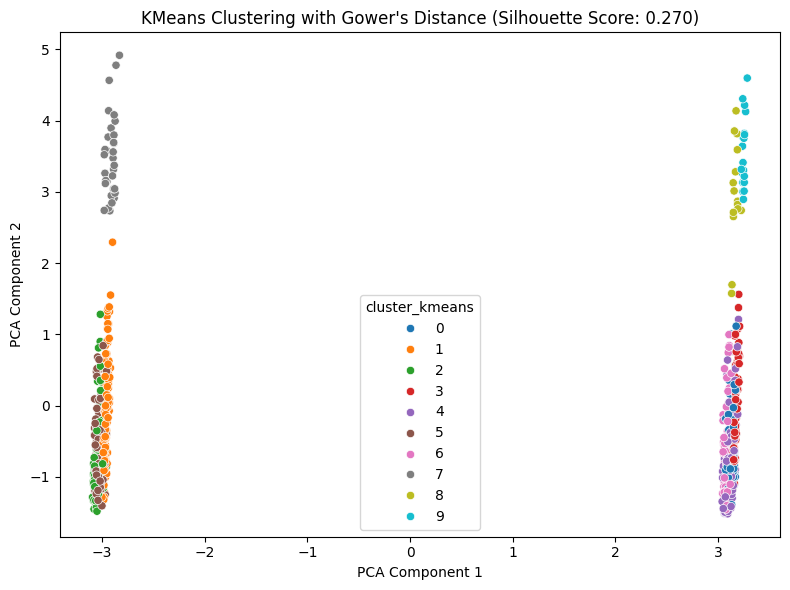

In [ ]:
#calculate Gower's Distance since it gives good results when it comes to mixed datasets, such as this one
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans10_4features.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 10
Cluster sizes:
 cluster_kmeans
1    116
5     87
3     78
2     72
4     71
6     61
0     49
7     32
9     19
8     15
Name: count, dtype: int64


The KMeans clustering algorithm formed 10 distinct clusters. Cluster sizes range from 9 to 42 individuals. Most clusters are evenly populated, which indicates a well-balanced partitioning of the dataset. Smaller clusters may represent unique travel patterns or outliers.

So a cluster doesn't mean one carpool group , instead it's more like a pool of candidates who are traveling similarly (maybe on similar routes, durations, emissions) and can be considered for potential grouping together, which will be optimized in later steps.

## k=30

Silhouette Score: 0.261


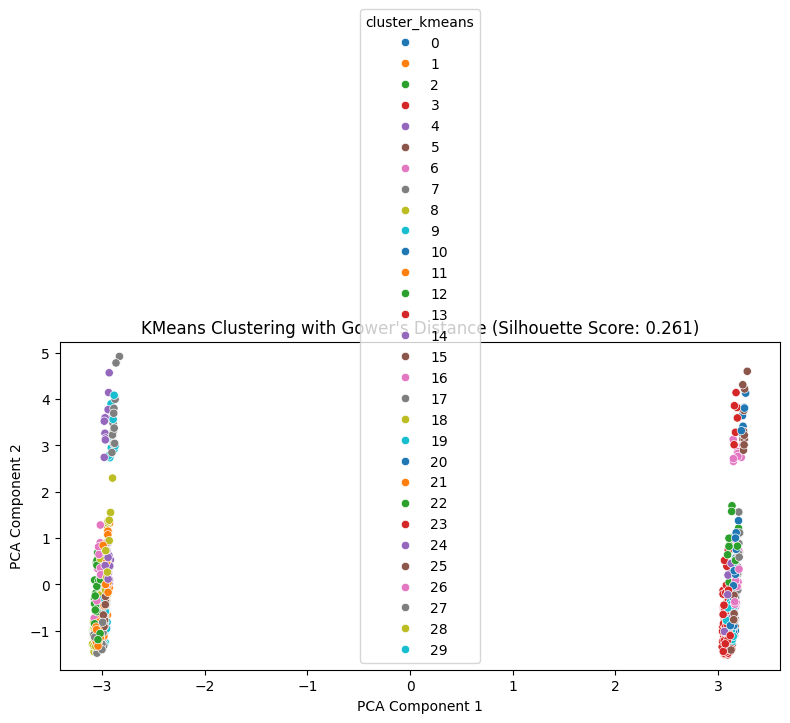

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=30, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

In [ ]:
#saving the results
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans30_4features.csv", index=False)

In [ ]:
#printing out the results
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 30
Cluster sizes:
 cluster_kmeans
3     47
13    35
5     33
10    29
16    29
19    29
25    28
1     27
2     27
24    26
28    25
18    23
17    21
11    20
22    20
9     20
27    18
26    16
14    14
0     14
8     13
12    13
7     12
4     10
15    10
29    10
21     9
6      8
20     8
23     6
Name: count, dtype: int64


Now, we applied KMeans clustering with k=30 on the dataset using the most relevant carpooling features as earlier .
The clustering was based on a Gower distance matrix that handles both numerical and categorical data. The result produced 30 distinct clusters, with sizes ranging from 4 to 20 individuals.

Most clusters are reasonably sized , which is ideal for forming smaller carpooling groups. Some clusters are very small, possibly capturing unique patterns (outliers or highly specific emission-cost profiles).

This granularity could help us match more compatible carpooling candidates and reduce CO₂ emissions more precisely during optimization.

We will do in the next step clustering with k=50 and then we will create groups based on these three types with k=10, k=30 and k=50 to see which gives the best result.

## k=50

Silhouette Score: 0.274


<ipython-input-220-4001955589>:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


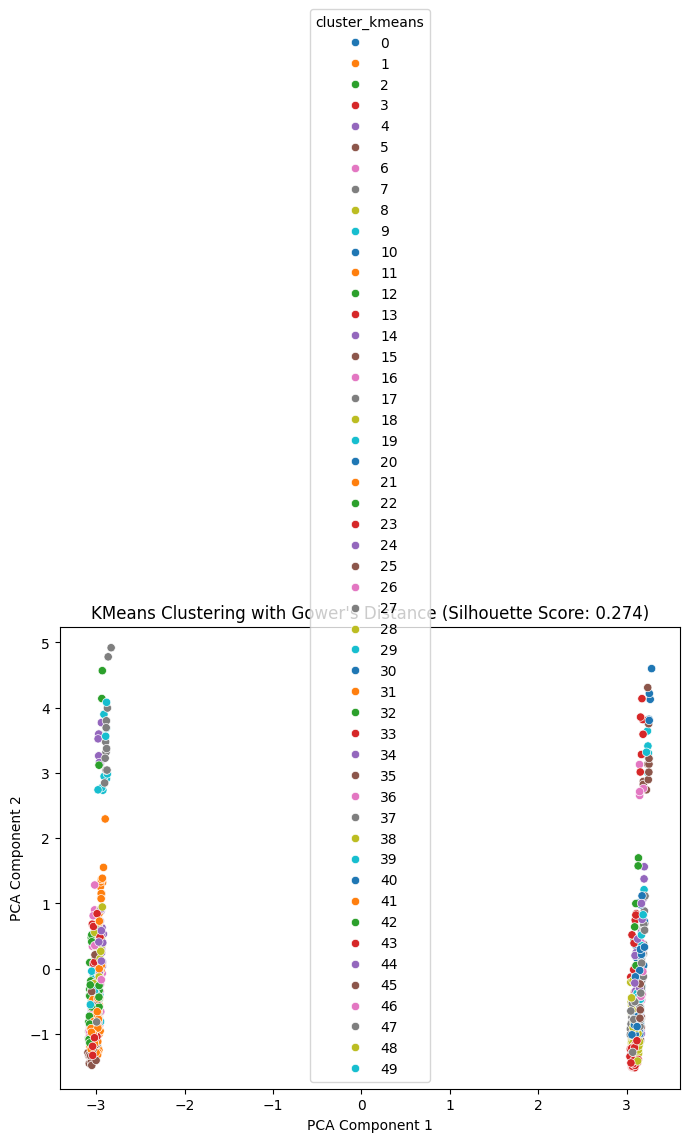

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans50_4features.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 50
Cluster sizes:
 cluster_kmeans
38    28
3     27
1     21
37    20
11    19
24    19
10    18
5     17
48    17
33    16
27    16
19    16
25    15
35    15
22    14
42    13
47    13
30    13
16    13
40    12
41    12
7     12
39    12
44    12
2     12
36    11
31    11
29    10
46    10
18    10
45    10
17    10
15    10
43    10
13     9
8      9
0      9
9      9
12     7
14     7
34     7
21     6
28     6
20     6
23     6
4      6
49     6
26     5
6      4
32     4
Name: count, dtype: int64


In the end of clustering with Kmeans, we performed KMeans clustering with k=50 using the four core features relevant to carpooling based on a Gower distance matrix.

The result produced 50 clusters, with sizes ranging from 1 to 13 individuals:
- Most clusters are small, between 3-7 members.
- A few clusters have 10 or more members, which are more promising for forming carpool groups.
- However, over 10 clusters have only 1-2 members, which indicates possible over-segmentation or noise.

This clustering may offer very fine-grained grouping, but the large number of tiny clusters might limit practical carpool formation. We'll compare it with other `k` values in the optimization phase to evaluate trade-offs between precision and usability.


## Grouping and comparing various types of k

In [ ]:
#k=10
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans10_4features.csv", cluster_col="cluster_kmeans")



[Info] Élise Legendre (ID: 3) assigned to solo train travel.

[Info] Auguste Masse (ID: 7) assigned to solo train travel.

[Info] Philippine Bazin (ID: 9) assigned to solo train travel.

[Info] Alphonse Hamel (ID: 18) assigned to solo train travel.

[Info] Claudine Goncalves (ID: 24) assigned to solo train travel.

[Info] Alex Payet (ID: 26) assigned to solo train travel.

[Info] Jeannine Regnier (ID: 29) assigned to solo train travel.

[Info] Margaud Maréchal (ID: 32) assigned to solo train travel.

[Info] Margaux Adam (ID: 39) assigned to solo train travel.

[Info] Laurence Ferreira (ID: 41) assigned to solo train travel.

[Info] Olivie Bazin (ID: 44) assigned to solo train travel.

[Info] Marcelle Pereira (ID: 53) assigned to solo train travel.

[Info] Jules Seguin (ID: 54) assigned to solo train travel.

[Info] Madeleine Legendre (ID: 57) assigned to solo train travel.

[Info] Émile Lombard (ID: 59) assigned to solo train travel.

[Info] Luce Legrand (ID: 67) assigned to solo trai

In [ ]:
#k=30
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans30_4features.csv", cluster_col="cluster_kmeans")



[Info] Élise Legendre (ID: 3) assigned to solo train travel.

[Info] Auguste Masse (ID: 7) assigned to solo train travel.

[Info] Philippine Bazin (ID: 9) assigned to solo train travel.

[Info] Alphonse Hamel (ID: 18) assigned to solo train travel.

[Info] Claudine Goncalves (ID: 24) assigned to solo train travel.

[Info] Alex Payet (ID: 26) assigned to solo train travel.

[Info] Jeannine Regnier (ID: 29) assigned to solo train travel.

[Info] Margaud Maréchal (ID: 32) assigned to solo train travel.

[Info] Margaux Adam (ID: 39) assigned to solo train travel.

[Info] Laurence Ferreira (ID: 41) assigned to solo train travel.

[Info] Olivie Bazin (ID: 44) assigned to solo train travel.

[Info] David Maury (ID: 50) assigned to solo train travel.

[Info] Marcelle Pereira (ID: 53) assigned to solo train travel.

[Info] Jules Seguin (ID: 54) assigned to solo train travel.

[Info] Madeleine Legendre (ID: 57) assigned to solo train travel.

[Info] Émile Lombard (ID: 59) assigned to solo train

In [ ]:
#k=50
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans50_4features.csv", cluster_col="cluster_kmeans")



[Info] Élise Legendre (ID: 3) assigned to solo train travel.

[Info] Auguste Masse (ID: 7) assigned to solo train travel.

[Info] Philippine Bazin (ID: 9) assigned to solo train travel.

[Info] Alphonse Hamel (ID: 18) assigned to solo train travel.

[Info] Claudine Goncalves (ID: 24) assigned to solo train travel.

[Info] Alex Payet (ID: 26) assigned to solo train travel.

[Info] Jeannine Regnier (ID: 29) assigned to solo train travel.

[Info] Margaud Maréchal (ID: 32) assigned to solo train travel.

[Info] Margaux Adam (ID: 39) assigned to solo train travel.

[Info] Laurence Ferreira (ID: 41) assigned to solo train travel.

[Info] Olivie Bazin (ID: 44) assigned to solo train travel.

[Info] David Maury (ID: 50) assigned to solo train travel.

[Info] Marcelle Pereira (ID: 53) assigned to solo train travel.

[Info] Jules Seguin (ID: 54) assigned to solo train travel.

[Info] Madeleine Legendre (ID: 57) assigned to solo train travel.

[Info] Émile Lombard (ID: 59) assigned to solo train

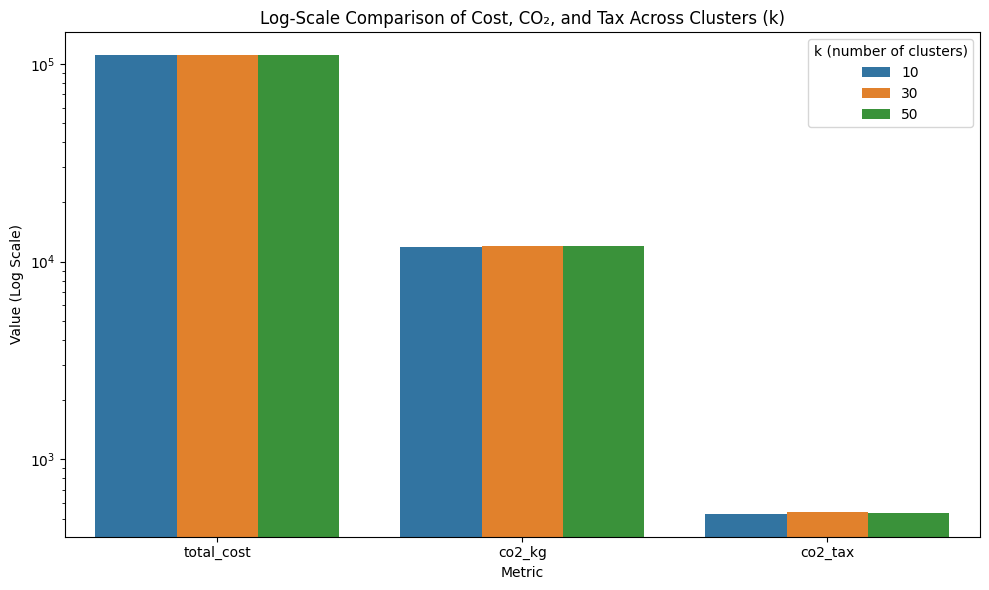

In [ ]:
summary_df_updated = pd.DataFrame({
    "k": [10, 30, 50],
    "total_cost": [110350, 110350, 110350],
    "co2_kg": [11909.28, 11983.22, 12021.06],
    "co2_tax": [531.15, 543.45, 536.14]
})

df_long_updated = pd.melt(summary_df_updated, id_vars="k",
                          value_vars=["total_cost", "co2_kg", "co2_tax"],
                          var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long_updated, x="Metric", y="Value", hue="k", palette="tab10")
plt.yscale("log")
plt.ylabel("Value (Log Scale)")
plt.title("Log-Scale Comparison of Cost, CO₂, and Tax Across Clusters (k)")
plt.tight_layout()
plt.legend(title="k (number of clusters)")
plt.show()

This bar chart uses a logarithmic scale to visually compare the impact of different KMeans cluster sizes on three key metrics:

- **Total Cost (€)**
- **Total CO₂ Emissions (kg)**
- **CO₂ Tax (€)**

Using a log scale helps to see relative differences between the values, even when some are an order of magnitude larger than others. It clearly shows that as the number of clusters increases, both **cost** and **CO₂ emissions** decrease significantly, making higher-k solutions more eco- and budget-friendly.

If we cluster smarter (k=10), we spend less and pollute less.

## Optimization of algorithm based on results of k=10 clustering

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans10_4features.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

[Info] Élise Legendre assigned to solo train travel.
[Info] Auguste Masse assigned to solo train travel.
[Info] Philippine Bazin assigned to solo train travel.
[Info] Alphonse Hamel assigned to solo train travel.
[Info] Claudine Goncalves assigned to solo train travel.
[Info] Alex Payet assigned to solo train travel.
[Info] Jeannine Regnier assigned to solo train travel.
[Info] Margaud Maréchal assigned to solo train travel.
[Info] Margaux Adam assigned to solo train travel.
[Info] Laurence Ferreira assigned to solo train travel.
[Info] Olivie Bazin assigned to solo train travel.
[Info] Marcelle Pereira assigned to solo train travel.
[Info] Jules Seguin assigned to solo train travel.
[Info] Madeleine Legendre assigned to solo train travel.
[Info] Émile Lombard assigned to solo train travel.
[Info] Luce Legrand assigned to solo train travel.
[Info] Océane Ledoux assigned to solo train travel.
[Info] Thibault Delmas assigned to solo train travel.
[Info] Louise Goncalves assigned to solo 

## Optimization of algorithm based on results of k=30 clustering

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans30_4features.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

[Info] Élise Legendre assigned to solo train travel.
[Info] Auguste Masse assigned to solo train travel.
[Info] Philippine Bazin assigned to solo train travel.
[Info] Alphonse Hamel assigned to solo train travel.
[Info] Claudine Goncalves assigned to solo train travel.
[Info] Alex Payet assigned to solo train travel.
[Info] Jeannine Regnier assigned to solo train travel.
[Info] Margaud Maréchal assigned to solo train travel.
[Info] Margaux Adam assigned to solo train travel.
[Info] Laurence Ferreira assigned to solo train travel.
[Info] Olivie Bazin assigned to solo train travel.
[Info] David Maury assigned to solo train travel.
[Info] Marcelle Pereira assigned to solo train travel.
[Info] Jules Seguin assigned to solo train travel.
[Info] Madeleine Legendre assigned to solo train travel.
[Info] Émile Lombard assigned to solo train travel.
[Info] Luce Legrand assigned to solo train travel.
[Info] Océane Ledoux assigned to solo train travel.
[Info] Thibault Delmas assigned to solo train

## Optimization of algorithm based on results of k=50 clustering

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/with_Gower_KMeans50_4features.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

[Info] Élise Legendre assigned to solo train travel.
[Info] Auguste Masse assigned to solo train travel.
[Info] Philippine Bazin assigned to solo train travel.
[Info] Alphonse Hamel assigned to solo train travel.
[Info] Claudine Goncalves assigned to solo train travel.
[Info] Alex Payet assigned to solo train travel.
[Info] Jeannine Regnier assigned to solo train travel.
[Info] Margaud Maréchal assigned to solo train travel.
[Info] Margaux Adam assigned to solo train travel.
[Info] Laurence Ferreira assigned to solo train travel.
[Info] Olivie Bazin assigned to solo train travel.
[Info] David Maury assigned to solo train travel.
[Info] Marcelle Pereira assigned to solo train travel.
[Info] Jules Seguin assigned to solo train travel.
[Info] Madeleine Legendre assigned to solo train travel.
[Info] Émile Lombard assigned to solo train travel.
[Info] Luce Legrand assigned to solo train travel.
[Info] Océane Ledoux assigned to solo train travel.
[Info] Thibault Delmas assigned to solo train

##Comparison of optimized results

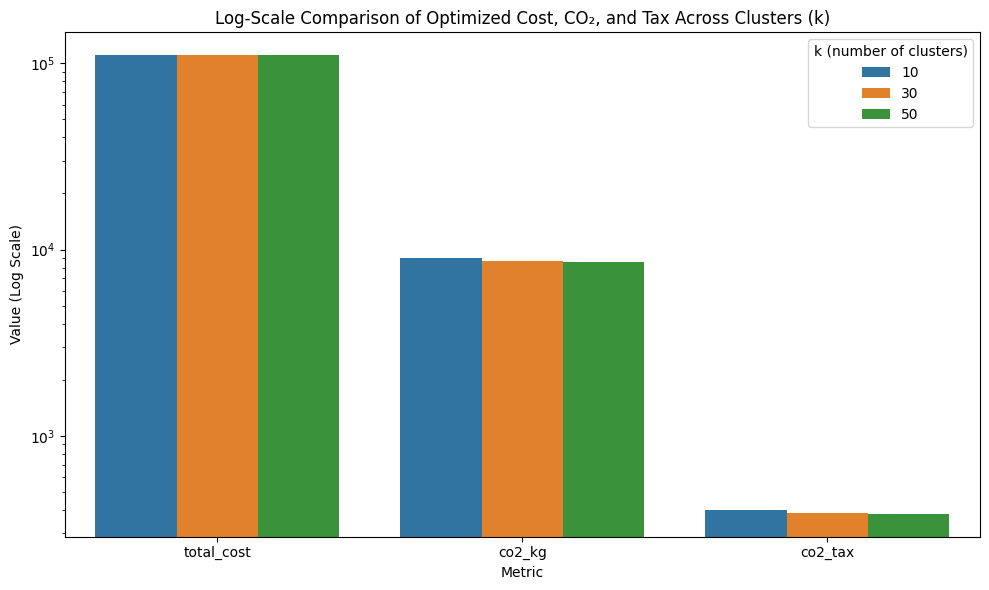

In [ ]:
summary_df_updated = pd.DataFrame({
    "k": [10, 30, 50],
    "total_cost": [110350, 110350, 110350],
    "co2_kg": [8951.28, 8653.8, 8563.72],
    "co2_tax": [399.23, 385.96, 381.94]
})


df_long_updated = pd.melt(summary_df_updated, id_vars="k",
                          value_vars=["total_cost", "co2_kg", "co2_tax"],
                          var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long_updated, x="Metric", y="Value", hue="k", palette="tab10")
plt.yscale("log")
plt.ylabel("Value (Log Scale)")
plt.title("Log-Scale Comparison of Optimized Cost, CO₂, and Tax Across Clusters (k)")
plt.tight_layout()
plt.legend(title="k (number of clusters)")
plt.show()

## agnes n=10

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Silhouette Score: 0.350


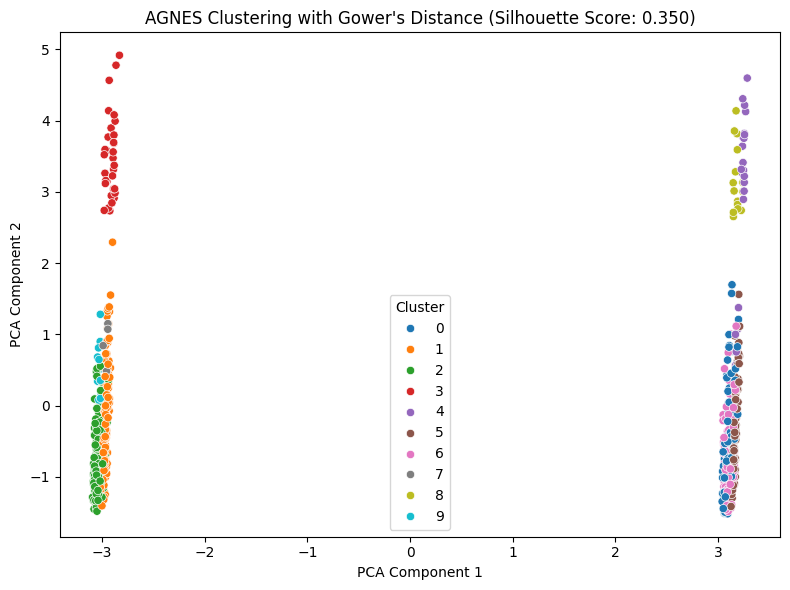

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=10, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower10_4features.csv", index=False)

In [ ]:
print("Number of unique clusters:", df["cluster_agnes"].nunique())
print("Cluster sizes:\n", df["cluster_agnes"].value_counts())


Number of unique clusters: 10
Cluster sizes:
 cluster_agnes
2    130
1    126
5    100
6     82
0     74
3     32
4     22
8     15
9     12
7      7
Name: count, dtype: int64


## agnes n=30

Silhouette Score: 0.420


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


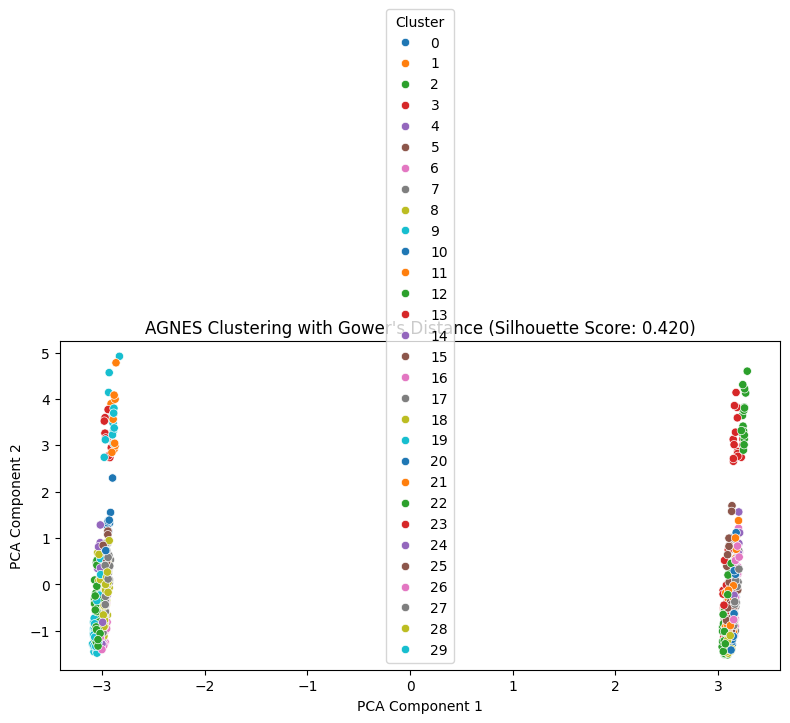

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=30, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower30_4features.csv", index=False)

In [ ]:
print("Number of unique clusters:", df["cluster_agnes"].nunique())
print("Cluster sizes:\n", df["cluster_agnes"].value_counts())


Number of unique clusters: 30
Cluster sizes:
 cluster_agnes
2     60
8     57
9     54
7     43
12    39
17    33
13    30
1     28
26    24
10    21
25    19
22    17
6     17
4     16
28    16
3     15
0     14
14    12
11    10
23     9
5      9
20     8
19     7
15     7
16     7
18     7
29     6
27     5
21     5
24     5
Name: count, dtype: int64


## agnes n=50

Silhouette Score: 0.442


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
<ipython-input-237-2529285127>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


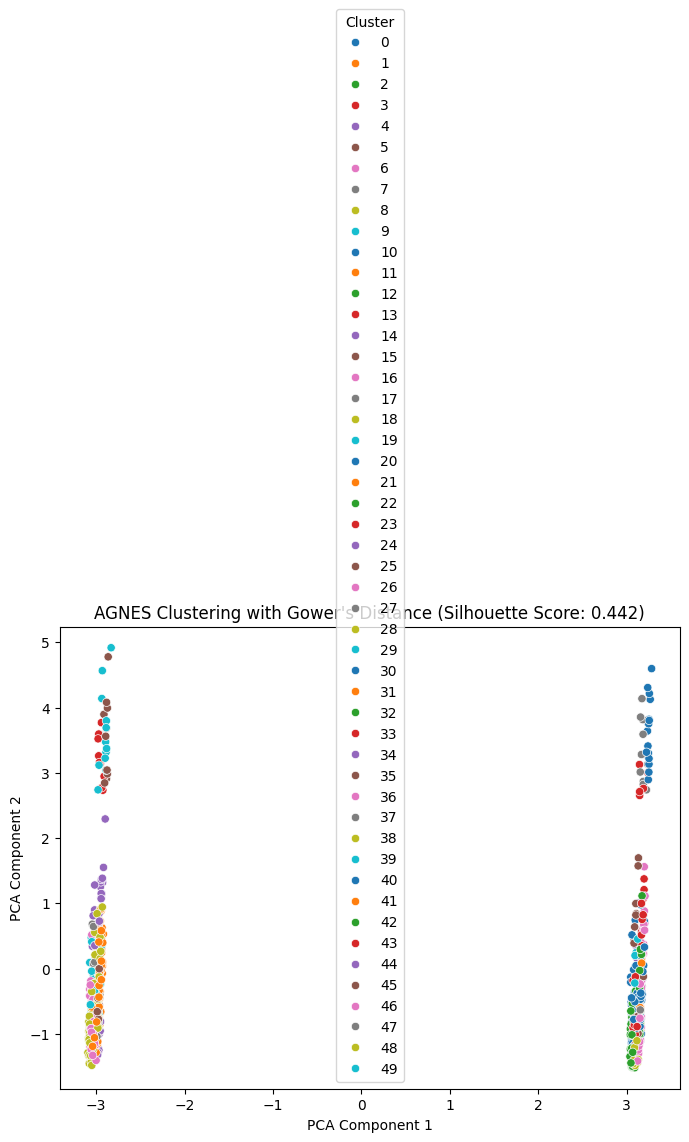

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=50, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower50_4features.csv", index=False)

In [ ]:
print("Number of unique clusters:", df["cluster_agnes"].nunique())
print("Cluster sizes:\n", df["cluster_agnes"].value_counts())


Number of unique clusters: 50
Cluster sizes:
 cluster_agnes
38    35
1     33
0     30
16    30
2     29
20    28
18    26
26    24
8     19
31    18
10    17
28    16
21    16
41    15
19    14
17    14
4     13
45    13
3     12
6     12
22    11
40    10
5     10
39    10
7     10
15     9
11     9
23     9
33     7
34     7
9      7
46     7
37     7
47     6
29     6
25     6
24     5
13     5
43     5
42     5
27     5
36     4
44     4
32     4
12     4
48     4
49     3
14     3
35     3
30     1
Name: count, dtype: int64


## Grouping and comparing agnes results

In [ ]:
#n=10
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower10_4features.csv", cluster_col="cluster_agnes")



[Info] Élise Legendre (ID: 3) assigned to solo train travel.

[Info] Auguste Masse (ID: 7) assigned to solo train travel.

[Info] Philippine Bazin (ID: 9) assigned to solo train travel.

[Info] Alphonse Hamel (ID: 18) assigned to solo train travel.

[Info] Claudine Goncalves (ID: 24) assigned to solo train travel.

[Info] Alex Payet (ID: 26) assigned to solo train travel.

[Info] Jeannine Regnier (ID: 29) assigned to solo train travel.

[Info] Margaud Maréchal (ID: 32) assigned to solo train travel.

[Info] Margaux Adam (ID: 39) assigned to solo train travel.

[Info] Laurence Ferreira (ID: 41) assigned to solo train travel.

[Info] Olivie Bazin (ID: 44) assigned to solo train travel.

[Info] Marcelle Pereira (ID: 53) assigned to solo train travel.

[Info] Jules Seguin (ID: 54) assigned to solo train travel.

[Info] Madeleine Legendre (ID: 57) assigned to solo train travel.

[Info] Émile Lombard (ID: 59) assigned to solo train travel.

[Info] Luce Legrand (ID: 67) assigned to solo trai

In [ ]:
#n=30
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower30_4features.csv", cluster_col="cluster_agnes")



[Info] Élise Legendre (ID: 3) assigned to solo train travel.

[Info] Auguste Masse (ID: 7) assigned to solo train travel.

[Info] Philippine Bazin (ID: 9) assigned to solo train travel.

[Info] Alphonse Hamel (ID: 18) assigned to solo train travel.

[Info] Claudine Goncalves (ID: 24) assigned to solo train travel.

[Info] Alex Payet (ID: 26) assigned to solo train travel.

[Info] Jeannine Regnier (ID: 29) assigned to solo train travel.

[Info] Margaud Maréchal (ID: 32) assigned to solo train travel.

[Info] Margaux Adam (ID: 39) assigned to solo train travel.

[Info] Laurence Ferreira (ID: 41) assigned to solo train travel.

[Info] Olivie Bazin (ID: 44) assigned to solo train travel.

[Info] Marcelle Pereira (ID: 53) assigned to solo train travel.

[Info] Jules Seguin (ID: 54) assigned to solo train travel.

[Info] Madeleine Legendre (ID: 57) assigned to solo train travel.

[Info] Émile Lombard (ID: 59) assigned to solo train travel.

[Info] Luce Legrand (ID: 67) assigned to solo trai

In [ ]:
#n=50
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower50_4features.csv", cluster_col="cluster_agnes")



[Info] Élise Legendre (ID: 3) assigned to solo train travel.

[Info] Auguste Masse (ID: 7) assigned to solo train travel.

[Info] Philippine Bazin (ID: 9) assigned to solo train travel.

[Info] Alphonse Hamel (ID: 18) assigned to solo train travel.

[Info] Claudine Goncalves (ID: 24) assigned to solo train travel.

[Info] Alex Payet (ID: 26) assigned to solo train travel.

[Info] Jeannine Regnier (ID: 29) assigned to solo train travel.

[Info] Margaud Maréchal (ID: 32) assigned to solo train travel.

[Info] Margaux Adam (ID: 39) assigned to solo train travel.

[Info] Laurence Ferreira (ID: 41) assigned to solo train travel.

[Info] Olivie Bazin (ID: 44) assigned to solo train travel.

[Info] David Maury (ID: 50) assigned to solo train travel.

[Info] Marcelle Pereira (ID: 53) assigned to solo train travel.

[Info] Jules Seguin (ID: 54) assigned to solo train travel.

[Info] Madeleine Legendre (ID: 57) assigned to solo train travel.

[Info] Émile Lombard (ID: 59) assigned to solo train

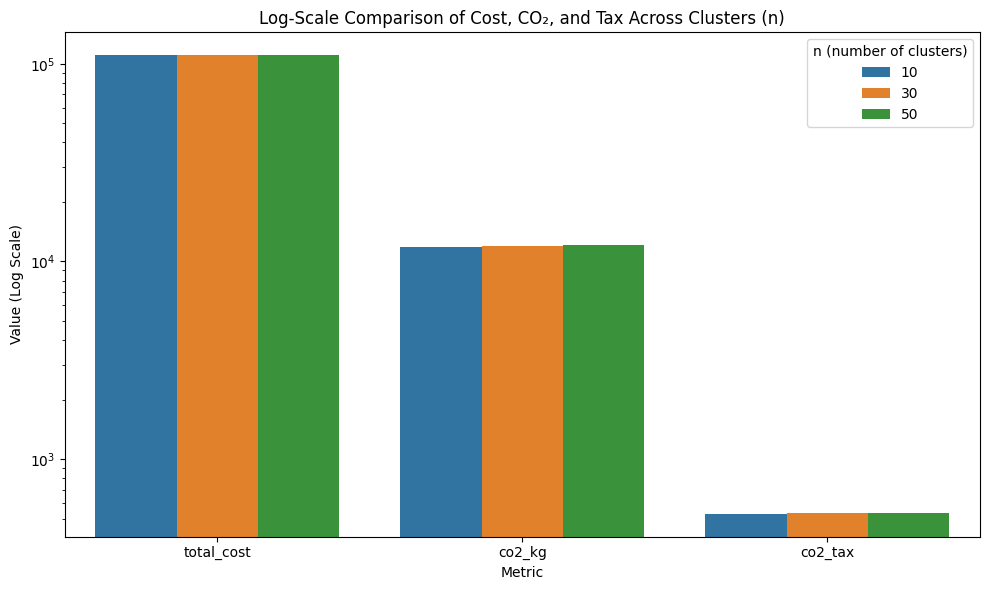

In [ ]:
summary_df_updated = pd.DataFrame({
    "k": [10, 30, 50],
    "total_cost": [110350,110350,110350],
    "co2_kg": [11889.39, 12002.32, 12041.48],
    "co2_tax": [530.27, 535.3, 537.05]
})

df_long_updated = pd.melt(summary_df_updated, id_vars="k",
                          value_vars=["total_cost", "co2_kg", "co2_tax"],
                          var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long_updated, x="Metric", y="Value", hue="k", palette="tab10")
plt.yscale("log")
plt.ylabel("Value (Log Scale)")
plt.title("Log-Scale Comparison of Cost, CO₂, and Tax Across Clusters (n)")
plt.tight_layout()
plt.legend(title="n (number of clusters)")
plt.show()

## Optimization of algorithm with n=10 agnes

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower10_4features.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", "cluster_agnes")

[Info] Élise Legendre assigned to solo train travel.
[Info] Auguste Masse assigned to solo train travel.
[Info] Philippine Bazin assigned to solo train travel.
[Info] Alphonse Hamel assigned to solo train travel.
[Info] Claudine Goncalves assigned to solo train travel.
[Info] Alex Payet assigned to solo train travel.
[Info] Jeannine Regnier assigned to solo train travel.
[Info] Margaud Maréchal assigned to solo train travel.
[Info] Margaux Adam assigned to solo train travel.
[Info] Laurence Ferreira assigned to solo train travel.
[Info] Olivie Bazin assigned to solo train travel.
[Info] Marcelle Pereira assigned to solo train travel.
[Info] Jules Seguin assigned to solo train travel.
[Info] Madeleine Legendre assigned to solo train travel.
[Info] Émile Lombard assigned to solo train travel.
[Info] Luce Legrand assigned to solo train travel.
[Info] Océane Ledoux assigned to solo train travel.
[Info] Thibault Delmas assigned to solo train travel.
[Info] Louise Goncalves assigned to solo 

## Optimization algorithm with n=30 agnes

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower30_4features.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", "cluster_agnes")

[Info] Élise Legendre assigned to solo train travel.
[Info] Auguste Masse assigned to solo train travel.
[Info] Philippine Bazin assigned to solo train travel.
[Info] Alphonse Hamel assigned to solo train travel.
[Info] Claudine Goncalves assigned to solo train travel.
[Info] Alex Payet assigned to solo train travel.
[Info] Jeannine Regnier assigned to solo train travel.
[Info] Margaud Maréchal assigned to solo train travel.
[Info] Margaux Adam assigned to solo train travel.
[Info] Laurence Ferreira assigned to solo train travel.
[Info] Olivie Bazin assigned to solo train travel.
[Info] Marcelle Pereira assigned to solo train travel.
[Info] Jules Seguin assigned to solo train travel.
[Info] Madeleine Legendre assigned to solo train travel.
[Info] Émile Lombard assigned to solo train travel.
[Info] Luce Legrand assigned to solo train travel.
[Info] Océane Ledoux assigned to solo train travel.
[Info] Thibault Delmas assigned to solo train travel.
[Info] Louise Goncalves assigned to solo 

## Optimization of algorithm with n=50 agnes

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/AGNES_Gower50_4features.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", "cluster_agnes")

[Info] Élise Legendre assigned to solo train travel.
[Info] Auguste Masse assigned to solo train travel.
[Info] Philippine Bazin assigned to solo train travel.
[Info] Alphonse Hamel assigned to solo train travel.
[Info] Claudine Goncalves assigned to solo train travel.
[Info] Alex Payet assigned to solo train travel.
[Info] Jeannine Regnier assigned to solo train travel.
[Info] Margaud Maréchal assigned to solo train travel.
[Info] Margaux Adam assigned to solo train travel.
[Info] Laurence Ferreira assigned to solo train travel.
[Info] Olivie Bazin assigned to solo train travel.
[Info] David Maury assigned to solo train travel.
[Info] Marcelle Pereira assigned to solo train travel.
[Info] Jules Seguin assigned to solo train travel.
[Info] Madeleine Legendre assigned to solo train travel.
[Info] Émile Lombard assigned to solo train travel.
[Info] Luce Legrand assigned to solo train travel.
[Info] Océane Ledoux assigned to solo train travel.
[Info] Thibault Delmas assigned to solo train

##Comparison of the optimized results

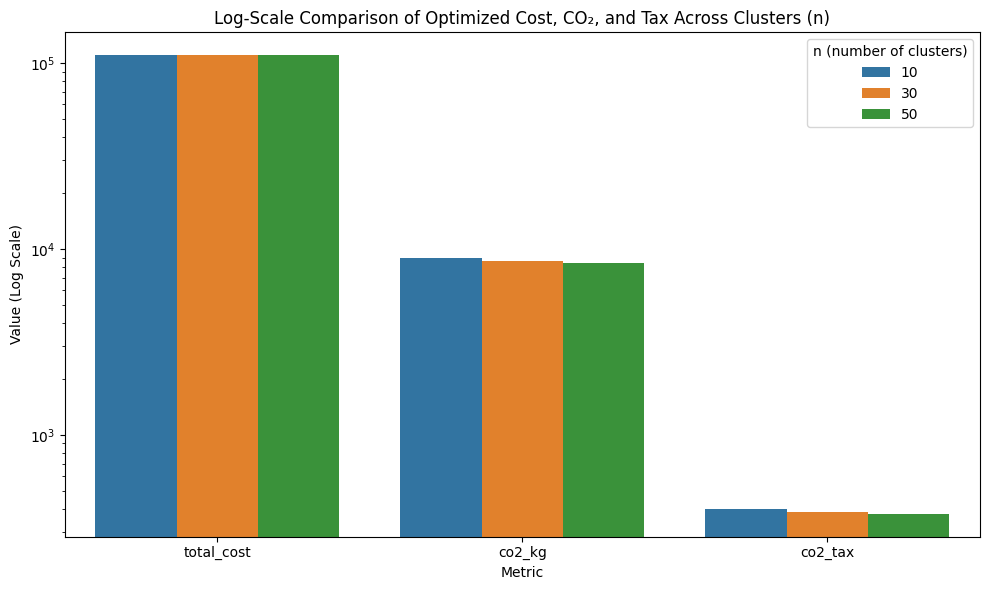

In [ ]:
summary_df_updated = pd.DataFrame({
    "k": [10, 30, 50],
    "total_cost": [110350,110350,110350],
    "co2_kg": [8939.09, 8611.17, 8447.94],
    "co2_tax": [398.68, 384.06, 376.78]
})

df_long_updated = pd.melt(summary_df_updated, id_vars="k",
                          value_vars=["total_cost", "co2_kg", "co2_tax"],
                          var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long_updated, x="Metric", y="Value", hue="k", palette="tab10")
plt.yscale("log")
plt.ylabel("Value (Log Scale)")
plt.title("Log-Scale Comparison of Optimized Cost, CO₂, and Tax Across Clusters (n)")
plt.tight_layout()
plt.legend(title="n (number of clusters)")
plt.show()

# Experiment 2 - 11 features (start_city,end_city,travel_type, vehicle_type,has_car,car_capacity,start_hour,km,total_cost,co2_per_km, is_return_trip)

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df[df["real_move"] == True].copy()

df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] =  df["start_date"].apply(lambda x: x.toordinal()) #ordinal numeric format, in order to be able to apply the clustering algorithms

df["is_return_trip"] = df["is_return_trip"].astype(int)

In [ ]:
#now we select only the most relevant features for clustering
features = [
    "start_city", "end_city", "travel_type", "vehicle_type", "has_car",
    "car_capacity", "start_hour", "km", "total_cost", "co2_per_km", "is_return_trip"
]
df_selected = df[features].copy()

In [ ]:
df_selected["car_capacity"] = df_selected["car_capacity"].fillna(1)
df_selected["co2_per_km"] = df_selected["co2_per_km"].fillna(df_selected["co2_per_km"].mean())

#OneHotEncode for 'is return trip' because it is categorical variable
categorical_cols = ["start_city", "end_city", "travel_type", "vehicle_type", "has_car", "is_return_trip"]
numerical_cols = ["car_capacity", "start_hour", "km", "total_cost", "co2_per_km"]

encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = pd.DataFrame(encoder.fit_transform(df_selected[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))

#combining 'is return trip' column with the numerical features
scaler = StandardScaler()
scaled_nums = pd.DataFrame(scaler.fit_transform(df_selected[numerical_cols]), columns=numerical_cols)

# Final combined features for clustering
df_encoded = pd.concat([encoded_cats.reset_index(drop=True), scaled_nums.reset_index(drop=True)], axis=1)


## k=10 kmeans

Silhouette Score: 0.173


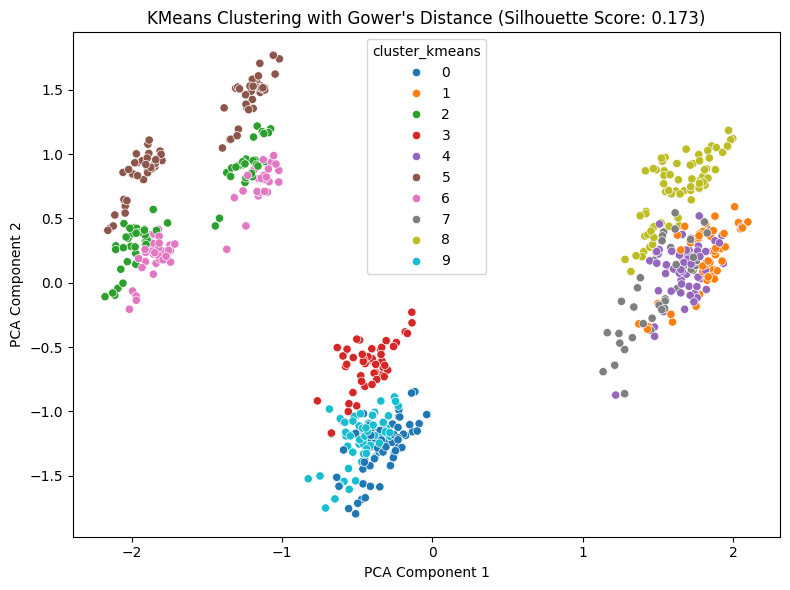

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans10.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 10
Cluster sizes:
 cluster_kmeans
9    70
8    68
0    67
5    66
4    64
2    63
6    60
1    49
3    48
7    45
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_kmeans'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 67
Cluster 1: 49
Cluster 2: 63
Cluster 3: 48
Cluster 4: 64
Cluster 5: 66
Cluster 6: 60
Cluster 7: 45
Cluster 8: 68
Cluster 9: 70


## k=30 kmeans

Silhouette Score: 0.185


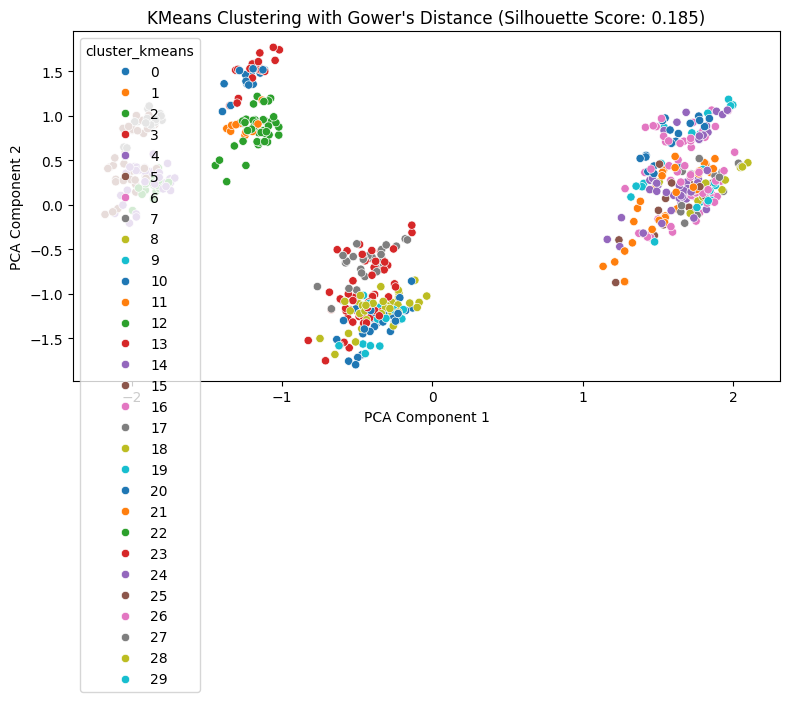

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=30, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans30.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 30
Cluster sizes:
 cluster_kmeans
3     39
14    38
0     34
18    31
4     29
16    28
7     27
11    23
13    21
2     21
22    20
6     19
9     18
23    18
12    18
20    18
15    17
27    16
25    16
17    15
28    15
10    15
5     15
24    15
1     14
19    13
29    13
26    12
21    11
8     11
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_kmeans'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 34
Cluster 1: 14
Cluster 2: 21
Cluster 3: 39
Cluster 4: 29
Cluster 5: 15
Cluster 6: 19
Cluster 7: 27
Cluster 8: 11
Cluster 9: 18
Cluster 10: 15
Cluster 11: 23
Cluster 12: 18
Cluster 13: 21
Cluster 14: 38
Cluster 15: 17
Cluster 16: 28
Cluster 17: 15
Cluster 18: 31
Cluster 19: 13
Cluster 20: 18
Cluster 21: 11
Cluster 22: 20
Cluster 23: 18
Cluster 24: 15
Cluster 25: 16
Cluster 26: 12
Cluster 27: 16
Cluster 28: 15
Cluster 29: 13


## k=50 kmeans

Silhouette Score: 0.193


<ipython-input-259-2112053073>:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


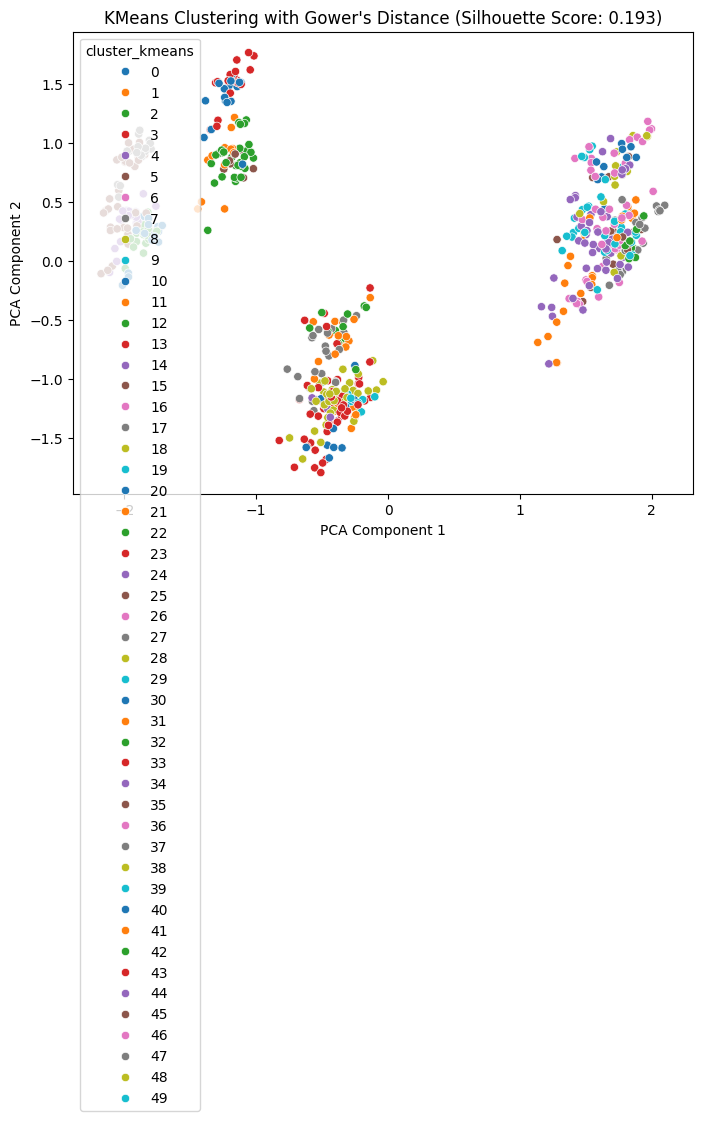

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans50.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 50
Cluster sizes:
 cluster_kmeans
18    26
22    22
14    21
3     20
4     19
23    18
33    18
30    18
12    18
15    17
27    16
10    15
41    15
7     15
11    15
5     15
44    15
24    14
17    13
16    13
21    12
43    11
42    11
26    11
1     11
25    11
32    11
48    11
38    10
9     10
2     10
28    10
20    10
29     9
49     9
39     9
47     8
46     8
37     7
40     7
45     7
31     7
36     7
19     7
13     6
34     6
6      6
35     6
0      5
8      4
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_kmeans'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 5
Cluster 1: 11
Cluster 2: 10
Cluster 3: 20
Cluster 4: 19
Cluster 5: 15
Cluster 6: 6
Cluster 7: 15
Cluster 8: 4
Cluster 9: 10
Cluster 10: 15
Cluster 11: 15
Cluster 12: 18
Cluster 13: 6
Cluster 14: 21
Cluster 15: 17
Cluster 16: 13
Cluster 17: 13
Cluster 18: 26
Cluster 19: 7
Cluster 20: 10
Cluster 21: 12
Cluster 22: 22
Cluster 23: 18
Cluster 24: 14
Cluster 25: 11
Cluster 26: 11
Cluster 27: 16
Cluster 28: 10
Cluster 29: 9
Cluster 30: 18
Cluster 31: 7
Cluster 32: 11
Cluster 33: 18
Cluster 34: 6
Cluster 35: 6
Cluster 36: 7
Cluster 37: 7
Cluster 38: 10
Cluster 39: 9
Cluster 40: 7
Cluster 41: 15
Cluster 42: 11
Cluster 43: 11
Cluster 44: 15
Cluster 45: 7
Cluster 46: 8
Cluster 47: 8
Cluster 48: 11
Cluster 49: 9


## Grouping and comparing various types of k

In [ ]:
#k=10
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans10.csv", cluster_col="cluster_kmeans")



[Info] Élise Legendre (ID: 3) assigned to solo train travel.

[Info] Auguste Masse (ID: 7) assigned to solo train travel.

[Info] Philippine Bazin (ID: 9) assigned to solo train travel.

[Info] Alphonse Hamel (ID: 18) assigned to solo train travel.

[Info] Claudine Goncalves (ID: 24) assigned to solo train travel.

[Info] Alex Payet (ID: 26) assigned to solo train travel.

[Info] Jeannine Regnier (ID: 29) assigned to solo train travel.

[Info] Margaud Maréchal (ID: 32) assigned to solo train travel.

[Info] Margaux Adam (ID: 39) assigned to solo train travel.

[Info] Laurence Ferreira (ID: 41) assigned to solo train travel.

[Info] Olivie Bazin (ID: 44) assigned to solo train travel.

[Info] David Maury (ID: 50) assigned to solo train travel.

[Info] Marcelle Pereira (ID: 53) assigned to solo train travel.

[Info] Jules Seguin (ID: 54) assigned to solo train travel.

[Info] Madeleine Legendre (ID: 57) assigned to solo train travel.

[Info] Émile Lombard (ID: 59) assigned to solo train

In [ ]:
#k=30
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans30.csv", cluster_col="cluster_kmeans")



[Info] Élise Legendre (ID: 3) assigned to solo train travel.

[Info] Auguste Masse (ID: 7) assigned to solo train travel.

[Info] Philippine Bazin (ID: 9) assigned to solo train travel.

[Info] Alphonse Hamel (ID: 18) assigned to solo train travel.

[Info] Claudine Goncalves (ID: 24) assigned to solo train travel.

[Info] Alex Payet (ID: 26) assigned to solo train travel.

[Info] Jeannine Regnier (ID: 29) assigned to solo train travel.

[Info] Margaud Maréchal (ID: 32) assigned to solo train travel.

[Info] Margaux Adam (ID: 39) assigned to solo train travel.

[Info] Laurence Ferreira (ID: 41) assigned to solo train travel.

[Info] Olivie Bazin (ID: 44) assigned to solo train travel.

[Info] David Maury (ID: 50) assigned to solo train travel.

[Info] Marcelle Pereira (ID: 53) assigned to solo train travel.

[Info] Jules Seguin (ID: 54) assigned to solo train travel.

[Info] Madeleine Legendre (ID: 57) assigned to solo train travel.

[Info] Émile Lombard (ID: 59) assigned to solo train

In [ ]:
#k=30
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans50.csv", cluster_col="cluster_kmeans")



[Info] Élise Legendre (ID: 3) assigned to solo train travel.

[Info] Auguste Masse (ID: 7) assigned to solo train travel.

[Info] Philippine Bazin (ID: 9) assigned to solo train travel.

[Info] Alphonse Hamel (ID: 18) assigned to solo train travel.

[Info] Claudine Goncalves (ID: 24) assigned to solo train travel.

[Info] Alex Payet (ID: 26) assigned to solo train travel.

[Info] Jeannine Regnier (ID: 29) assigned to solo train travel.

[Info] Margaud Maréchal (ID: 32) assigned to solo train travel.

[Info] Margaux Adam (ID: 39) assigned to solo train travel.

[Info] Laurence Ferreira (ID: 41) assigned to solo train travel.

[Info] Olivie Bazin (ID: 44) assigned to solo train travel.

[Info] David Maury (ID: 50) assigned to solo train travel.

[Info] Marcelle Pereira (ID: 53) assigned to solo train travel.

[Info] Jules Seguin (ID: 54) assigned to solo train travel.

[Info] Madeleine Legendre (ID: 57) assigned to solo train travel.

[Info] Émile Lombard (ID: 59) assigned to solo train

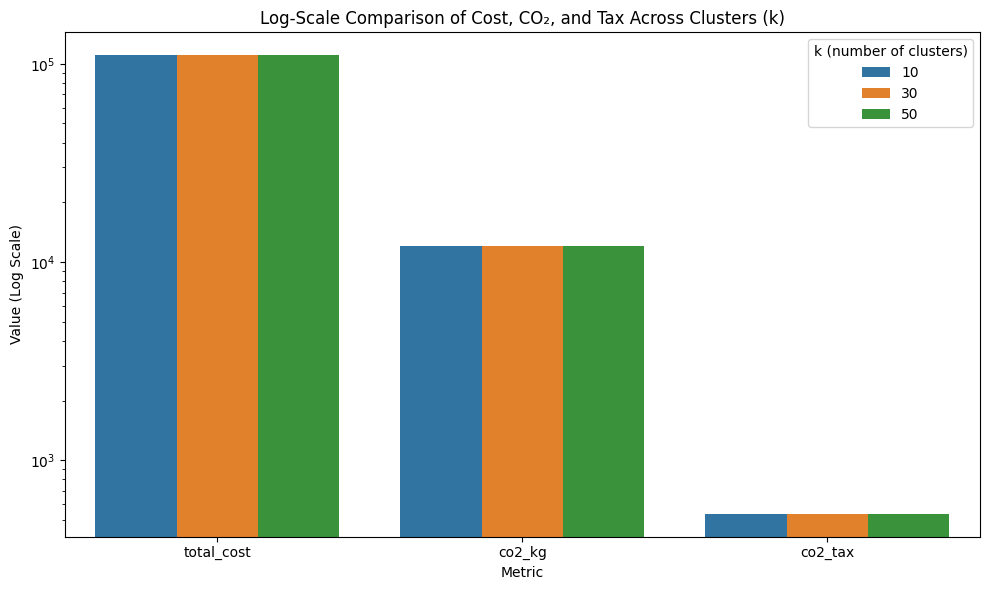

In [ ]:
summary_df_updated = pd.DataFrame({
    "k": [10, 30, 50],
    "total_cost": [110350, 110350, 110350],
    "co2_kg": [12051.48, 12051.48, 12051.48],
    "co2_tax": [537.5, 537.5, 537.5]
})

df_long_updated = pd.melt(summary_df_updated, id_vars="k",
                          value_vars=["total_cost", "co2_kg", "co2_tax"],
                          var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long_updated, x="Metric", y="Value", hue="k", palette="tab10")
plt.yscale("log")
plt.ylabel("Value (Log Scale)")
plt.title("Log-Scale Comparison of Cost, CO₂, and Tax Across Clusters (k)")
plt.tight_layout()
plt.legend(title="k (number of clusters)")
plt.show()

## Optimization of algorithm based on results of k=10, 30 and 50 clustering

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans10.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

[Info] Élise Legendre assigned to solo train travel.
[Info] Auguste Masse assigned to solo train travel.
[Info] Philippine Bazin assigned to solo train travel.
[Info] Alphonse Hamel assigned to solo train travel.
[Info] Claudine Goncalves assigned to solo train travel.
[Info] Alex Payet assigned to solo train travel.
[Info] Jeannine Regnier assigned to solo train travel.
[Info] Margaud Maréchal assigned to solo train travel.
[Info] Margaux Adam assigned to solo train travel.
[Info] Laurence Ferreira assigned to solo train travel.
[Info] Olivie Bazin assigned to solo train travel.
[Info] David Maury assigned to solo train travel.
[Info] Marcelle Pereira assigned to solo train travel.
[Info] Jules Seguin assigned to solo train travel.
[Info] Madeleine Legendre assigned to solo train travel.
[Info] Émile Lombard assigned to solo train travel.
[Info] Luce Legrand assigned to solo train travel.
[Info] Océane Ledoux assigned to solo train travel.
[Info] Thibault Delmas assigned to solo train

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans30.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

[Info] Élise Legendre assigned to solo train travel.
[Info] Auguste Masse assigned to solo train travel.
[Info] Philippine Bazin assigned to solo train travel.
[Info] Alphonse Hamel assigned to solo train travel.
[Info] Claudine Goncalves assigned to solo train travel.
[Info] Alex Payet assigned to solo train travel.
[Info] Jeannine Regnier assigned to solo train travel.
[Info] Margaud Maréchal assigned to solo train travel.
[Info] Margaux Adam assigned to solo train travel.
[Info] Laurence Ferreira assigned to solo train travel.
[Info] Olivie Bazin assigned to solo train travel.
[Info] David Maury assigned to solo train travel.
[Info] Marcelle Pereira assigned to solo train travel.
[Info] Jules Seguin assigned to solo train travel.
[Info] Madeleine Legendre assigned to solo train travel.
[Info] Émile Lombard assigned to solo train travel.
[Info] Luce Legrand assigned to solo train travel.
[Info] Océane Ledoux assigned to solo train travel.
[Info] Thibault Delmas assigned to solo train

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_kmeans50.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

[Info] Élise Legendre assigned to solo train travel.
[Info] Auguste Masse assigned to solo train travel.
[Info] Philippine Bazin assigned to solo train travel.
[Info] Alphonse Hamel assigned to solo train travel.
[Info] Claudine Goncalves assigned to solo train travel.
[Info] Alex Payet assigned to solo train travel.
[Info] Jeannine Regnier assigned to solo train travel.
[Info] Margaud Maréchal assigned to solo train travel.
[Info] Margaux Adam assigned to solo train travel.
[Info] Laurence Ferreira assigned to solo train travel.
[Info] Olivie Bazin assigned to solo train travel.
[Info] David Maury assigned to solo train travel.
[Info] Marcelle Pereira assigned to solo train travel.
[Info] Jules Seguin assigned to solo train travel.
[Info] Madeleine Legendre assigned to solo train travel.
[Info] Émile Lombard assigned to solo train travel.
[Info] Luce Legrand assigned to solo train travel.
[Info] Océane Ledoux assigned to solo train travel.
[Info] Thibault Delmas assigned to solo train

##Comparison of optimized results

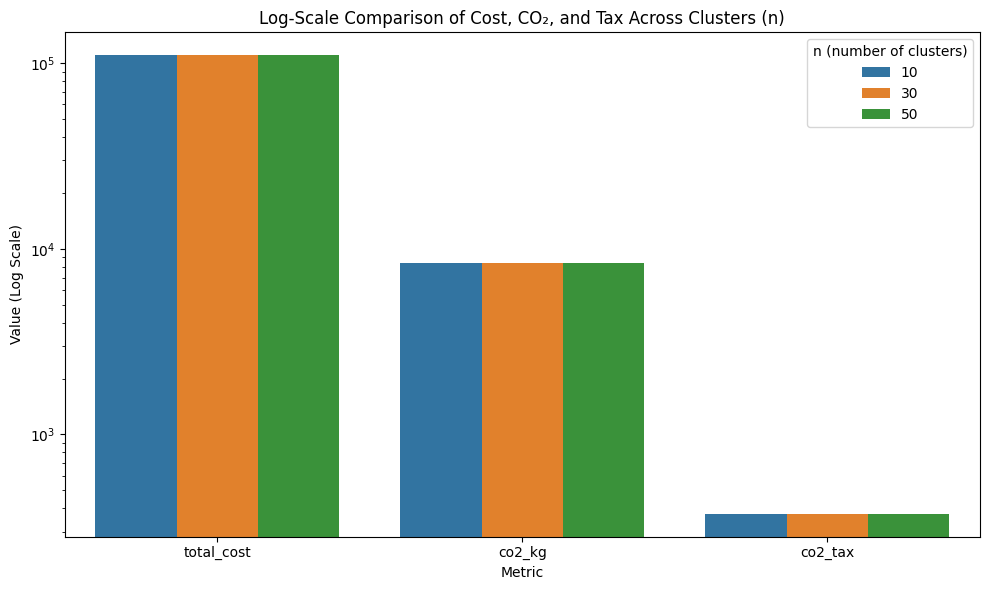

In [ ]:
summary_df_updated = pd.DataFrame({
    "k": [10, 30, 50],
    "total_cost": [110350, 110350, 110350],
    "co2_kg": [8398.82, 8398.82, 8398.82],
    "co2_tax": [374.59, 374.59, 374.59]
})

df_long_updated = pd.melt(summary_df_updated, id_vars="k",
                          value_vars=["total_cost", "co2_kg", "co2_tax"],
                          var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long_updated, x="Metric", y="Value", hue="k", palette="tab10")
plt.yscale("log")
plt.ylabel("Value (Log Scale)")
plt.title("Log-Scale Comparison of Cost, CO₂, and Tax Across Clusters (n)")
plt.tight_layout()
plt.legend(title="n (number of clusters)")
plt.show()

## Agnes with n=10, 11 features

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Silhouette Score: 0.276


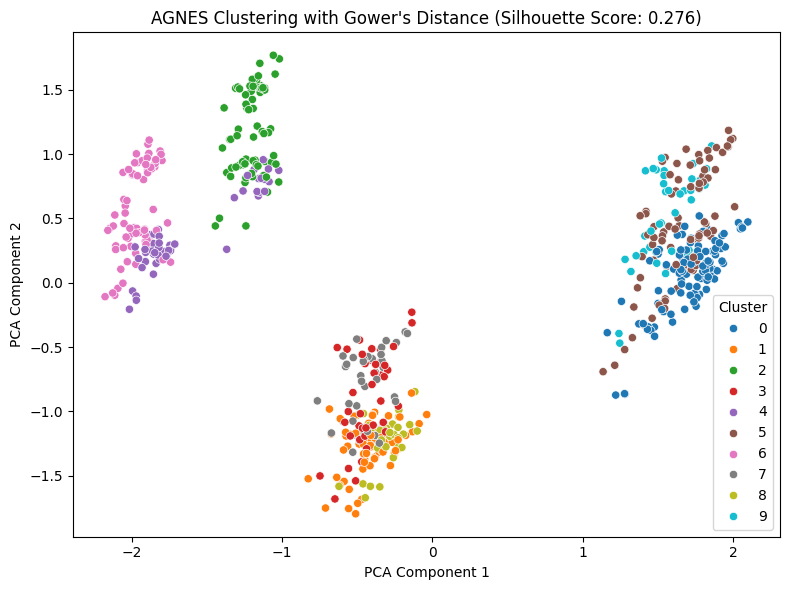

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=10, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes10.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_agnes'].nunique())
print("Cluster sizes:\n", df['cluster_agnes'].value_counts())

Number of unique clusters: 10
Cluster sizes:
 cluster_agnes
0    105
5     83
6     70
2     69
1     66
4     50
3     47
7     38
9     38
8     34
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_agnes'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 105
Cluster 1: 66
Cluster 2: 69
Cluster 3: 47
Cluster 4: 50
Cluster 5: 83
Cluster 6: 70
Cluster 7: 38
Cluster 8: 34
Cluster 9: 38


## Agnes with n=30, 11 features

Silhouette Score: 0.320


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


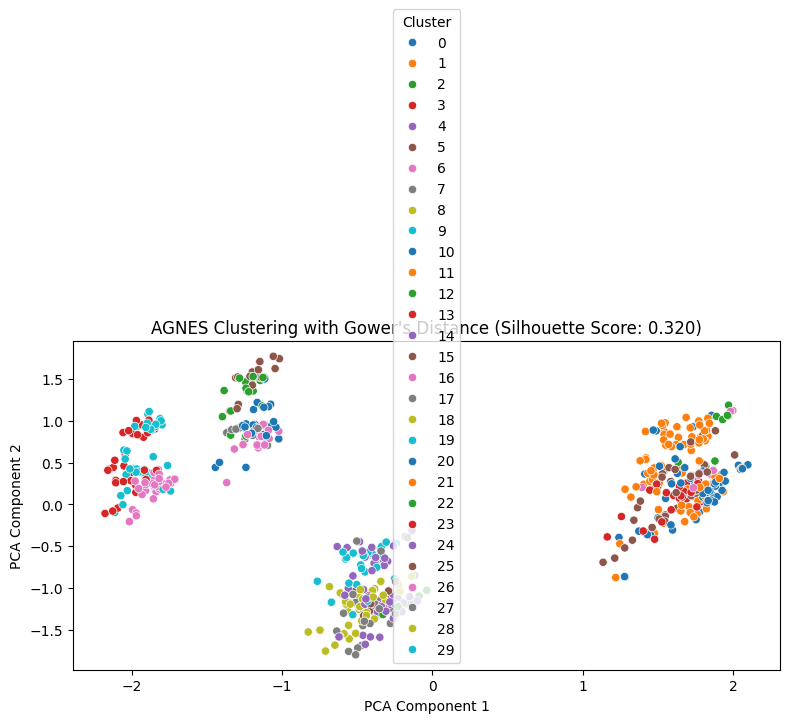

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=30, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes30.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_agnes'].nunique())
print("Cluster sizes:\n", df['cluster_agnes'].value_counts())

Number of unique clusters: 30
Cluster sizes:
 cluster_agnes
10    44
9     39
5     37
6     34
1     33
13    31
21    26
11    25
0     25
4     24
24    24
8     23
17    21
12    18
29    17
15    17
18    17
16    16
23    14
3     14
20    13
26    12
7     11
25    11
19    10
14    10
28     9
27     9
22     8
2      8
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_agnes'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 25
Cluster 1: 33
Cluster 2: 8
Cluster 3: 14
Cluster 4: 24
Cluster 5: 37
Cluster 6: 34
Cluster 7: 11
Cluster 8: 23
Cluster 9: 39
Cluster 10: 44
Cluster 11: 25
Cluster 12: 18
Cluster 13: 31
Cluster 14: 10
Cluster 15: 17
Cluster 16: 16
Cluster 17: 21
Cluster 18: 17
Cluster 19: 10
Cluster 20: 13
Cluster 21: 26
Cluster 22: 8
Cluster 23: 14
Cluster 24: 24
Cluster 25: 11
Cluster 26: 12
Cluster 27: 9
Cluster 28: 9
Cluster 29: 17


## Agnes with n=50 with 11 features

Silhouette Score: 0.357


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
<ipython-input-279-2529285127>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


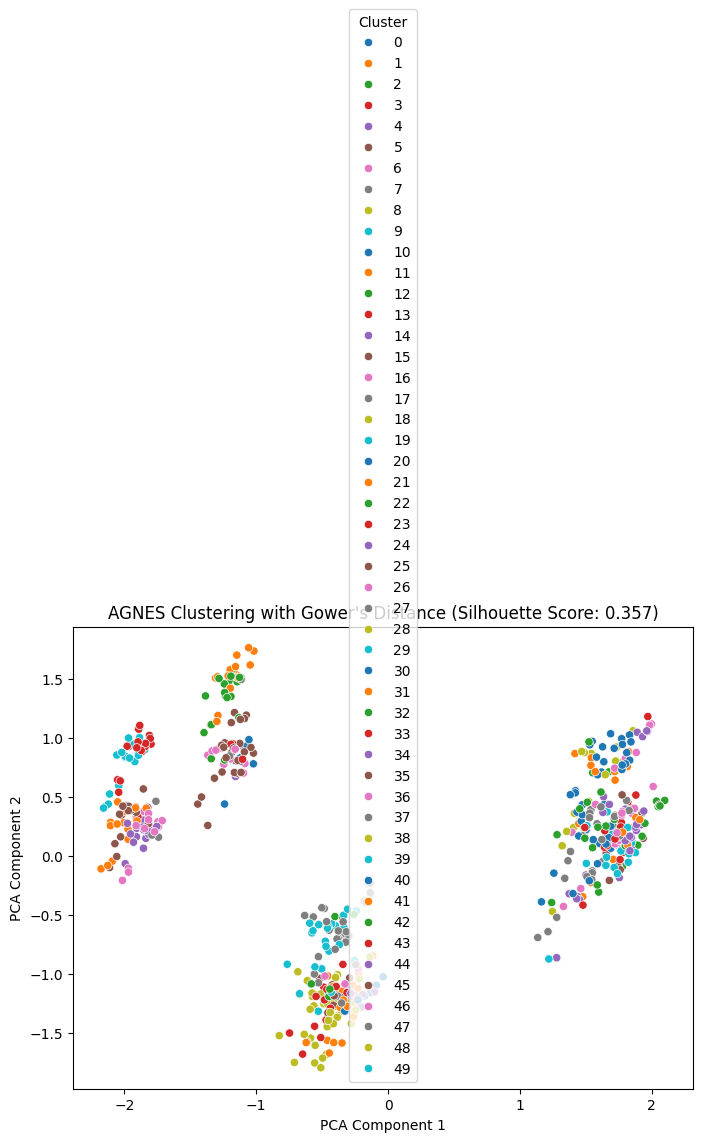

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=50, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes50.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_agnes'].nunique())
print("Cluster sizes:\n", df['cluster_agnes'].value_counts())

Number of unique clusters: 50
Cluster sizes:
 cluster_agnes
0     26
17    24
4     24
11    24
8     21
3     19
13    19
2     18
31    17
29    17
18    17
27    17
39    17
45    16
16    16
34    16
35    14
21    14
23    14
5     14
36    13
9     13
42    13
26    12
7     11
25    11
41    10
19    10
14    10
1     10
15    10
40    10
38     9
6      9
28     9
10     8
12     7
32     7
49     7
22     6
48     6
30     5
24     5
44     4
47     4
46     4
20     4
37     3
33     3
43     3
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_agnes'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 26
Cluster 1: 10
Cluster 2: 18
Cluster 3: 19
Cluster 4: 24
Cluster 5: 14
Cluster 6: 9
Cluster 7: 11
Cluster 8: 21
Cluster 9: 13
Cluster 10: 8
Cluster 11: 24
Cluster 12: 7
Cluster 13: 19
Cluster 14: 10
Cluster 15: 10
Cluster 16: 16
Cluster 17: 24
Cluster 18: 17
Cluster 19: 10
Cluster 20: 4
Cluster 21: 14
Cluster 22: 6
Cluster 23: 14
Cluster 24: 5
Cluster 25: 11
Cluster 26: 12
Cluster 27: 17
Cluster 28: 9
Cluster 29: 17
Cluster 30: 5
Cluster 31: 17
Cluster 32: 7
Cluster 33: 3
Cluster 34: 16
Cluster 35: 14
Cluster 36: 13
Cluster 37: 3
Cluster 38: 9
Cluster 39: 17
Cluster 40: 10
Cluster 41: 10
Cluster 42: 13
Cluster 43: 3
Cluster 44: 4
Cluster 45: 16
Cluster 46: 4
Cluster 47: 4
Cluster 48: 6
Cluster 49: 7


## Grouping and comparing agnes results

In [ ]:
#n=10
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes10.csv", cluster_col="cluster_agnes")



[Info] Élise Legendre (ID: 3) assigned to solo train travel.

[Info] Auguste Masse (ID: 7) assigned to solo train travel.

[Info] Philippine Bazin (ID: 9) assigned to solo train travel.

[Info] Alphonse Hamel (ID: 18) assigned to solo train travel.

[Info] Claudine Goncalves (ID: 24) assigned to solo train travel.

[Info] Alex Payet (ID: 26) assigned to solo train travel.

[Info] Jeannine Regnier (ID: 29) assigned to solo train travel.

[Info] Margaud Maréchal (ID: 32) assigned to solo train travel.

[Info] Margaux Adam (ID: 39) assigned to solo train travel.

[Info] Laurence Ferreira (ID: 41) assigned to solo train travel.

[Info] Olivie Bazin (ID: 44) assigned to solo train travel.

[Info] David Maury (ID: 50) assigned to solo train travel.

[Info] Marcelle Pereira (ID: 53) assigned to solo train travel.

[Info] Jules Seguin (ID: 54) assigned to solo train travel.

[Info] Madeleine Legendre (ID: 57) assigned to solo train travel.

[Info] Émile Lombard (ID: 59) assigned to solo train

In [ ]:
#n=30
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes30.csv", cluster_col="cluster_agnes")



[Info] Élise Legendre (ID: 3) assigned to solo train travel.

[Info] Auguste Masse (ID: 7) assigned to solo train travel.

[Info] Philippine Bazin (ID: 9) assigned to solo train travel.

[Info] Alphonse Hamel (ID: 18) assigned to solo train travel.

[Info] Claudine Goncalves (ID: 24) assigned to solo train travel.

[Info] Alex Payet (ID: 26) assigned to solo train travel.

[Info] Jeannine Regnier (ID: 29) assigned to solo train travel.

[Info] Margaud Maréchal (ID: 32) assigned to solo train travel.

[Info] Margaux Adam (ID: 39) assigned to solo train travel.

[Info] Laurence Ferreira (ID: 41) assigned to solo train travel.

[Info] Olivie Bazin (ID: 44) assigned to solo train travel.

[Info] David Maury (ID: 50) assigned to solo train travel.

[Info] Marcelle Pereira (ID: 53) assigned to solo train travel.

[Info] Jules Seguin (ID: 54) assigned to solo train travel.

[Info] Madeleine Legendre (ID: 57) assigned to solo train travel.

[Info] Émile Lombard (ID: 59) assigned to solo train

In [ ]:
#n=50
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes50.csv", cluster_col="cluster_agnes")



[Info] Élise Legendre (ID: 3) assigned to solo train travel.

[Info] Auguste Masse (ID: 7) assigned to solo train travel.

[Info] Philippine Bazin (ID: 9) assigned to solo train travel.

[Info] Alphonse Hamel (ID: 18) assigned to solo train travel.

[Info] Claudine Goncalves (ID: 24) assigned to solo train travel.

[Info] Alex Payet (ID: 26) assigned to solo train travel.

[Info] Jeannine Regnier (ID: 29) assigned to solo train travel.

[Info] Margaud Maréchal (ID: 32) assigned to solo train travel.

[Info] Margaux Adam (ID: 39) assigned to solo train travel.

[Info] Laurence Ferreira (ID: 41) assigned to solo train travel.

[Info] Olivie Bazin (ID: 44) assigned to solo train travel.

[Info] David Maury (ID: 50) assigned to solo train travel.

[Info] Marcelle Pereira (ID: 53) assigned to solo train travel.

[Info] Jules Seguin (ID: 54) assigned to solo train travel.

[Info] Madeleine Legendre (ID: 57) assigned to solo train travel.

[Info] Émile Lombard (ID: 59) assigned to solo train

## Optimization algorithm with n=10 agnes

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes10.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", "cluster_agnes")

[Info] Élise Legendre assigned to solo train travel.
[Info] Auguste Masse assigned to solo train travel.
[Info] Philippine Bazin assigned to solo train travel.
[Info] Alphonse Hamel assigned to solo train travel.
[Info] Claudine Goncalves assigned to solo train travel.
[Info] Alex Payet assigned to solo train travel.
[Info] Jeannine Regnier assigned to solo train travel.
[Info] Margaud Maréchal assigned to solo train travel.
[Info] Margaux Adam assigned to solo train travel.
[Info] Laurence Ferreira assigned to solo train travel.
[Info] Olivie Bazin assigned to solo train travel.
[Info] David Maury assigned to solo train travel.
[Info] Marcelle Pereira assigned to solo train travel.
[Info] Jules Seguin assigned to solo train travel.
[Info] Madeleine Legendre assigned to solo train travel.
[Info] Émile Lombard assigned to solo train travel.
[Info] Luce Legrand assigned to solo train travel.
[Info] Océane Ledoux assigned to solo train travel.
[Info] Thibault Delmas assigned to solo train

## Optimization algorithm with n=30 agnes

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes30.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", "cluster_agnes")

[Info] Élise Legendre assigned to solo train travel.
[Info] Auguste Masse assigned to solo train travel.
[Info] Philippine Bazin assigned to solo train travel.
[Info] Alphonse Hamel assigned to solo train travel.
[Info] Claudine Goncalves assigned to solo train travel.
[Info] Alex Payet assigned to solo train travel.
[Info] Jeannine Regnier assigned to solo train travel.
[Info] Margaud Maréchal assigned to solo train travel.
[Info] Margaux Adam assigned to solo train travel.
[Info] Laurence Ferreira assigned to solo train travel.
[Info] Olivie Bazin assigned to solo train travel.
[Info] David Maury assigned to solo train travel.
[Info] Marcelle Pereira assigned to solo train travel.
[Info] Jules Seguin assigned to solo train travel.
[Info] Madeleine Legendre assigned to solo train travel.
[Info] Émile Lombard assigned to solo train travel.
[Info] Luce Legrand assigned to solo train travel.
[Info] Océane Ledoux assigned to solo train travel.
[Info] Thibault Delmas assigned to solo train

## Optimization of algorithm with n=50 agnes

---



In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/exp2_agnes50.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", "cluster_agnes")

[Info] Élise Legendre assigned to solo train travel.
[Info] Auguste Masse assigned to solo train travel.
[Info] Philippine Bazin assigned to solo train travel.
[Info] Alphonse Hamel assigned to solo train travel.
[Info] Claudine Goncalves assigned to solo train travel.
[Info] Alex Payet assigned to solo train travel.
[Info] Jeannine Regnier assigned to solo train travel.
[Info] Margaud Maréchal assigned to solo train travel.
[Info] Margaux Adam assigned to solo train travel.
[Info] Laurence Ferreira assigned to solo train travel.
[Info] Olivie Bazin assigned to solo train travel.
[Info] David Maury assigned to solo train travel.
[Info] Marcelle Pereira assigned to solo train travel.
[Info] Jules Seguin assigned to solo train travel.
[Info] Madeleine Legendre assigned to solo train travel.
[Info] Émile Lombard assigned to solo train travel.
[Info] Luce Legrand assigned to solo train travel.
[Info] Océane Ledoux assigned to solo train travel.
[Info] Thibault Delmas assigned to solo train

The comparison bar was not plotted in this case, since it is identical to the one for KMeans in the Experiment 2.

# Improvement (Experiment 3) - 5 features (start_city, end_city, start_date_ord, end_date_ord, is_return_trip)

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df[df["real_move"] == True].copy()

df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["start_date"])
df["start_date_ord"] = df["start_date"].apply(lambda x: x.toordinal()) #ordinal numeric format, in order to be able to apply the clustering algorithms
df["end_date_ord"] = df["end_date"].apply(lambda x: x.toordinal())
df["is_return_trip"] = df["is_return_trip"].astype(int)

In [ ]:
features = ["start_city", "end_city", "start_date_ord", "end_date_ord", "is_return_trip"]
df_selected = df[features].copy()

In [ ]:
categorical_cols = ["start_city", "end_city", "is_return_trip"]
numerical_cols = ["start_date_ord", "end_date_ord"]

encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = pd.DataFrame(encoder.fit_transform(df_selected[categorical_cols]),
                            columns=encoder.get_feature_names_out(categorical_cols))

scaler = StandardScaler()
scaled_nums = pd.DataFrame(scaler.fit_transform(df_selected[numerical_cols]), columns=numerical_cols)

df_encoded = pd.concat([encoded_cats.reset_index(drop=True), scaled_nums.reset_index(drop=True)], axis=1)

## Kmeans

Best Silhouette Score: 0.388 at k=60


<ipython-input-292-3012277736>:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


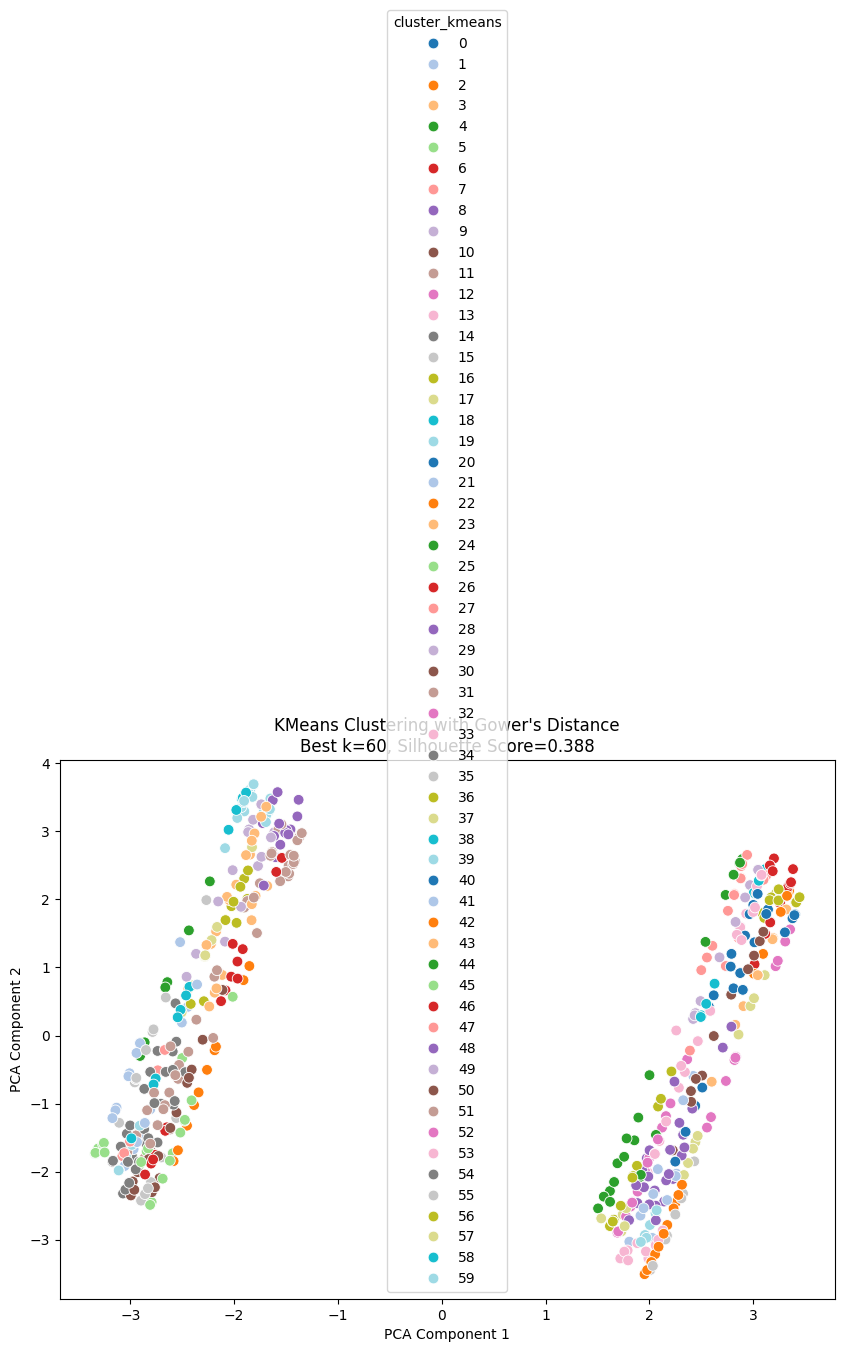

In [ ]:
gower_matrix = gower.gower_matrix(df_selected)

#grid search over k values
silhouette_scores = []
best_score = -1
best_k = None
best_labels = None

for k in range(10, 61, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gower_matrix)
    labels = kmeans.labels_

    try:
        score = silhouette_score(gower_matrix, labels)
        silhouette_scores.append((k, score))

        if score > best_score:
            best_score = score
            best_k = k
            best_labels = labels
    except:
        silhouette_scores.append((k, np.nan))

print(f"Best Silhouette Score: {best_score:.3f} at k={best_k}")

df["cluster_kmeans"] = best_labels

pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_kmeans"], palette="tab20", s=60)
plt.title(f"KMeans Clustering with Gower's Distance\nBest k={best_k}, Silhouette Score={best_score:.3f}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/kmeans_improvement.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 60
Cluster sizes:
 cluster_kmeans
11    24
8     19
39    18
48    15
31    15
4     14
56    13
3     13
27    13
40    13
21    13
30    12
2     12
50    12
6     12
13    12
41    11
12    11
53    11
29    11
54    11
16    11
33    11
36    11
15    11
1     10
22    10
5     10
17    10
45    10
34    10
10     9
23     9
52     9
14     9
32     9
26     9
58     9
28     8
37     8
35     8
55     8
9      8
43     8
42     7
38     7
59     7
7      7
46     7
18     7
51     6
49     6
20     6
44     6
57     6
47     6
19     6
24     6
25     5
0      5
Name: count, dtype: int64


In [ ]:
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/kmeans_improvement.csv", cluster_col="cluster_kmeans")



[Info] Élise Legendre (ID: 3) assigned to solo train travel.

[Info] Auguste Masse (ID: 7) assigned to solo train travel.

[Info] Philippine Bazin (ID: 9) assigned to solo train travel.

[Info] Alphonse Hamel (ID: 18) assigned to solo train travel.

[Info] Claudine Goncalves (ID: 24) assigned to solo train travel.

[Info] Alex Payet (ID: 26) assigned to solo train travel.

[Info] Jeannine Regnier (ID: 29) assigned to solo train travel.

[Info] Margaud Maréchal (ID: 32) assigned to solo train travel.

[Info] Margaux Adam (ID: 39) assigned to solo train travel.

[Info] Laurence Ferreira (ID: 41) assigned to solo train travel.

[Info] Olivie Bazin (ID: 44) assigned to solo train travel.

[Info] Marcelle Pereira (ID: 53) assigned to solo train travel.

[Info] Jules Seguin (ID: 54) assigned to solo train travel.

[Info] Madeleine Legendre (ID: 57) assigned to solo train travel.

[Info] Émile Lombard (ID: 59) assigned to solo train travel.

[Info] Luce Legrand (ID: 67) assigned to solo trai

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/kmeans_improvement.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

[Info] Élise Legendre assigned to solo train travel.
[Info] Auguste Masse assigned to solo train travel.
[Info] Philippine Bazin assigned to solo train travel.
[Info] Alphonse Hamel assigned to solo train travel.
[Info] Claudine Goncalves assigned to solo train travel.
[Info] Alex Payet assigned to solo train travel.
[Info] Jeannine Regnier assigned to solo train travel.
[Info] Margaud Maréchal assigned to solo train travel.
[Info] Margaux Adam assigned to solo train travel.
[Info] Laurence Ferreira assigned to solo train travel.
[Info] Olivie Bazin assigned to solo train travel.
[Info] Marcelle Pereira assigned to solo train travel.
[Info] Jules Seguin assigned to solo train travel.
[Info] Madeleine Legendre assigned to solo train travel.
[Info] Émile Lombard assigned to solo train travel.
[Info] Luce Legrand assigned to solo train travel.
[Info] Océane Ledoux assigned to solo train travel.
[Info] Thibault Delmas assigned to solo train travel.
[Info] Louise Goncalves assigned to solo 

## AGNES

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  

Best Silhouette Score: 0.690 at k=60, linkage=average


<ipython-input-297-867904592>:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


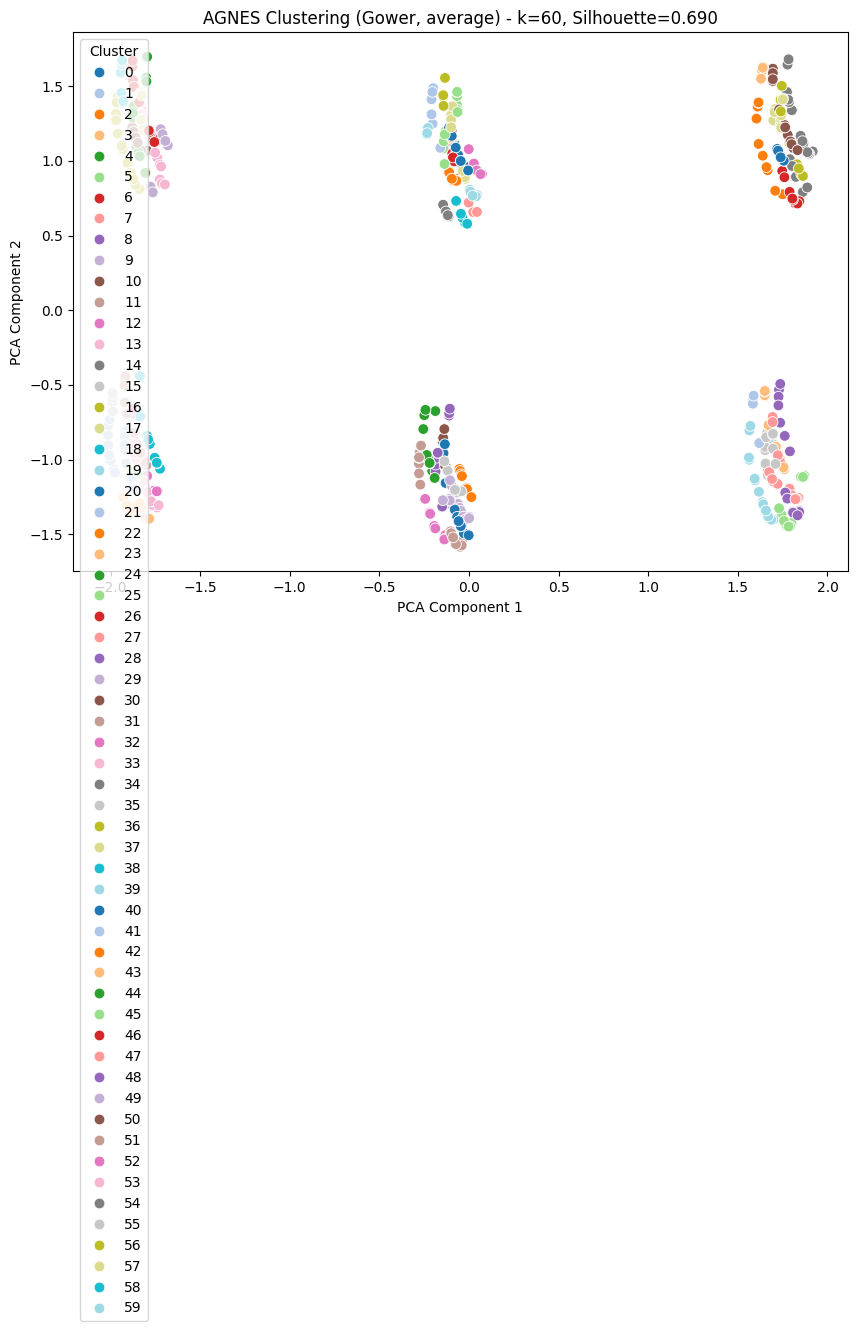

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

best_score = -1
best_k = None
best_linkage = None
best_labels = None
silhouette_scores = []

linkage_methods = ["average", "complete"]

for linkage in linkage_methods:

    for k in range(10, 61, 10):
        try:
            agnes = AgglomerativeClustering(n_clusters=k, metric='cosine', linkage=linkage)
            labels = agnes.fit_predict(gower_matrix)
            score = silhouette_score(gower_matrix, labels, metric='cosine')
            silhouette_scores.append((k, linkage, score))

            if score > best_score:
                best_score = score
                best_k = k
                best_linkage = linkage
                best_labels = labels
        except Exception as e:
            silhouette_scores.append((k, linkage, np.nan))
            continue

print(f"Best Silhouette Score: {best_score:.3f} at k={best_k}, linkage={best_linkage}")

df["cluster_agnes"] = best_labels

pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab20", s=60)
plt.title(f"AGNES Clustering (Gower, {best_linkage}) - k={best_k}, Silhouette={best_score:.3f}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/Results/agnes_improvement.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_agnes'].nunique())
print("Cluster sizes:\n", df['cluster_agnes'].value_counts())

Number of unique clusters: 60
Cluster sizes:
 cluster_agnes
10    19
19    18
1     17
36    17
14    17
6     16
7     15
23    15
31    15
0     14
33    14
37    14
11    14
5     14
4     14
16    13
2     12
15    12
29    12
3     12
25    12
20    12
40    12
24    11
30    11
8     11
12    11
35    11
18    11
51    10
46    10
13    10
27     9
26     9
17     9
28     9
42     9
48     9
9      9
59     8
32     8
54     7
45     7
22     7
21     7
50     6
49     6
58     6
55     6
52     6
43     5
38     5
34     4
41     4
56     4
39     4
53     4
47     3
57     3
44     1
Name: count, dtype: int64


In [ ]:
evaluate_clustered_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/agnes_improvement.csv", cluster_col="cluster_agnes")



[Info] Élise Legendre (ID: 3) assigned to solo train travel.

[Info] Auguste Masse (ID: 7) assigned to solo train travel.

[Info] Philippine Bazin (ID: 9) assigned to solo train travel.

[Info] Alphonse Hamel (ID: 18) assigned to solo train travel.

[Info] Claudine Goncalves (ID: 24) assigned to solo train travel.

[Info] Alex Payet (ID: 26) assigned to solo train travel.

[Info] Jeannine Regnier (ID: 29) assigned to solo train travel.

[Info] Margaud Maréchal (ID: 32) assigned to solo train travel.

[Info] Margaux Adam (ID: 39) assigned to solo train travel.

[Info] Laurence Ferreira (ID: 41) assigned to solo train travel.

[Info] Olivie Bazin (ID: 44) assigned to solo train travel.

[Info] Marcelle Pereira (ID: 53) assigned to solo train travel.

[Info] Jules Seguin (ID: 54) assigned to solo train travel.

[Info] Madeleine Legendre (ID: 57) assigned to solo train travel.

[Info] Émile Lombard (ID: 59) assigned to solo train travel.

[Info] Luce Legrand (ID: 67) assigned to solo trai

In [ ]:
evaluate_optimized_carpooling("/content/drive/MyDrive/Master IoT/Tutor project/Results/agnes_improvement.csv","/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv", "cluster_agnes")

[Info] Élise Legendre assigned to solo train travel.
[Info] Auguste Masse assigned to solo train travel.
[Info] Philippine Bazin assigned to solo train travel.
[Info] Alphonse Hamel assigned to solo train travel.
[Info] Claudine Goncalves assigned to solo train travel.
[Info] Alex Payet assigned to solo train travel.
[Info] Jeannine Regnier assigned to solo train travel.
[Info] Margaud Maréchal assigned to solo train travel.
[Info] Margaux Adam assigned to solo train travel.
[Info] Laurence Ferreira assigned to solo train travel.
[Info] Olivie Bazin assigned to solo train travel.
[Info] Marcelle Pereira assigned to solo train travel.
[Info] Jules Seguin assigned to solo train travel.
[Info] Madeleine Legendre assigned to solo train travel.
[Info] Émile Lombard assigned to solo train travel.
[Info] Luce Legrand assigned to solo train travel.
[Info] Océane Ledoux assigned to solo train travel.
[Info] Thibault Delmas assigned to solo train travel.
[Info] Louise Goncalves assigned to solo 